In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format='retina'
import collections
import copy
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['mathtext.rm'] = 'serif'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
rcParams['axes.titlepad'] = 12

In [2]:
import processing_functions as pf

In [3]:
reload(pf)

<module 'processing_functions' from 'processing_functions.pyc'>

In [4]:
jkcov = (np.load('Run_102218/jk_20p5_x.npz')['jkcov']+np.load('Run_102218/jk_20p5_y.npz')['jkcov']\
             +np.load('Run_102218/jk_20p5_z.npz')['jkcov'])/3.
fidreal = np.load('Run_102218/fidreal_20p5.npz')['func']
fidrandom = np.load('Run_102218/fidrandom_20p5.npz')
threshold = '-20.5'
pertfunc_dict,pertparam = pf.load_pert(threshold)

covtot = pf.calc_covariance(jkcov,fidreal,fidrandom)
cov_cut = pf.cut_by_func_2D(covtot,funcidx={'w':range(30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,116),'a':range(120,146),'r':range(150,180)})
invcov_cut = pf.apply_to_dict(pf.inv_cov,cov_cut,rcond=1e-4)

average_curves = pf.mean_of_dict(pertfunc_dict)

func_cut = pf.cut_by_func_1D(average_curves,axis=1,funcidx={'w':range(30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,116),'a':range(120,146),'r':range(150,180)})

p0 = pf.p0_list[threshold]
oneside = pf.oneside_dict[threshold]

gcv_alphas = pf.gcv_alphas(average_curves,pertparam)
gcv_alphas_cut = pf.cut_by_func_1D(gcv_alphas,axis=1,funcidx={'w':range(30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,116),'a':range(120,146),'r':range(150,180)})

covtot_20p5 = copy.deepcopy(covtot)
pertparam_20p5 = copy.deepcopy(pertparam)
average_curves_20p5 = copy.deepcopy(average_curves)
gcv_alphas_20p5 = copy.deepcopy(gcv_alphas)
%store covtot_20p5
%store pertparam_20p5
%store average_curves_20p5
%store gcv_alphas_20p5

Stored 'covtot_20p5' (ndarray)
Stored 'pertparam_20p5' (ndarray)
Stored 'average_curves_20p5' (ndarray)
Stored 'gcv_alphas_20p5' (ndarray)


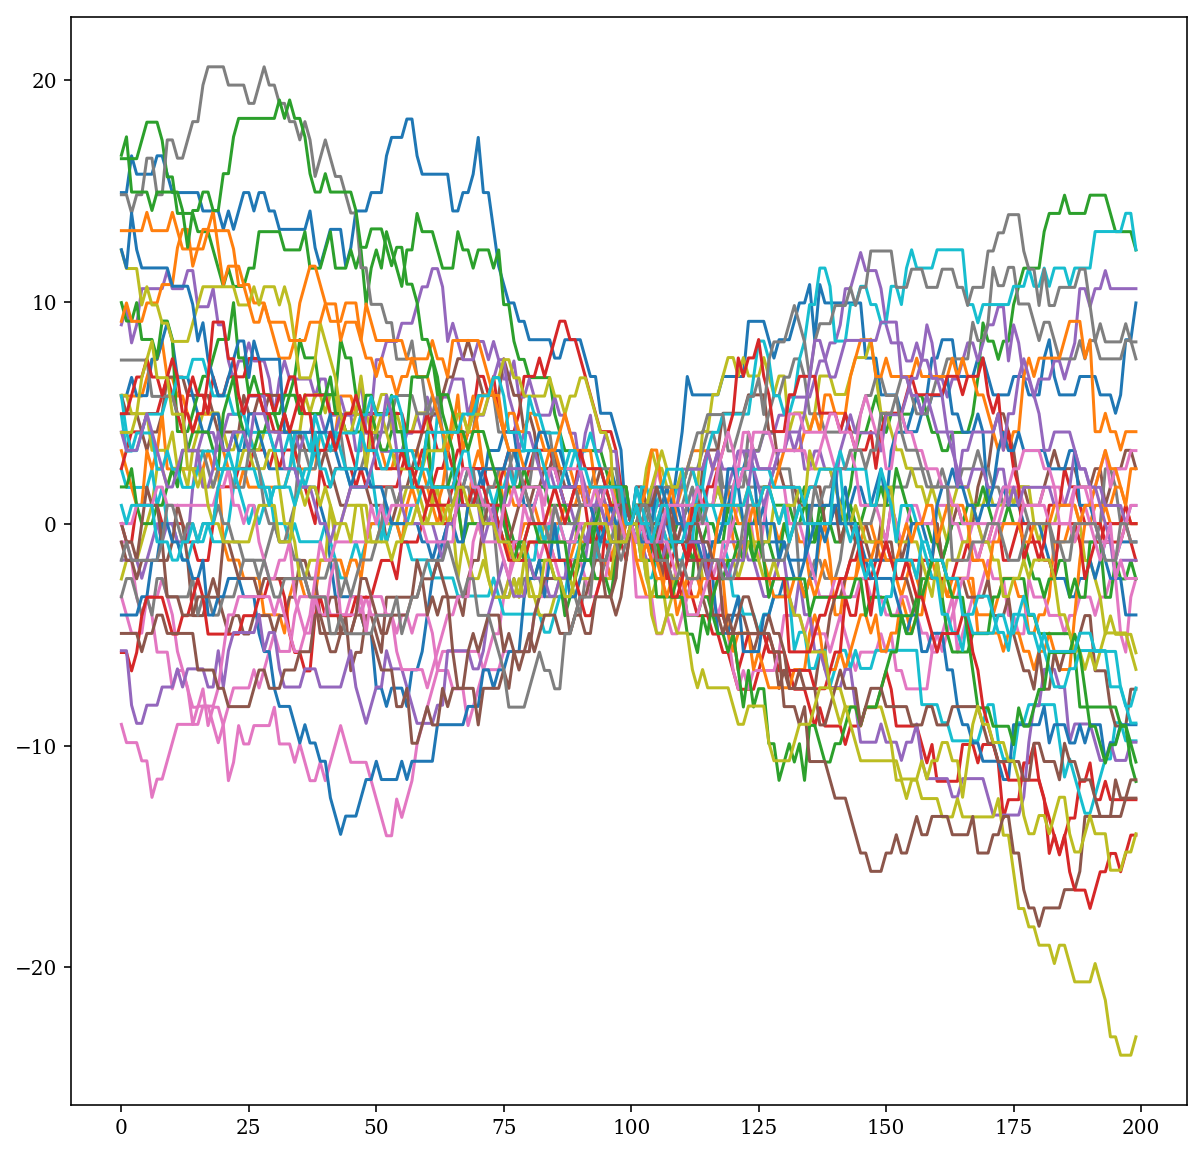

In [15]:
plt.figure(figsize=(10,10))
for seed in pertfunc_dict.keys():
    plt.plot(pertfunc_dict[seed][800:1000,1]-pertfunc_dict[seed][900,1])

In [5]:
def iterate_smooth(combkey, maxiter=5):  #for each combination separately
    it = 0
    iter_sigma = []
    iter_sigma.append(np.zeros(6))
    f = func_cut[combkey]
    alphas = np.ones((6,f.shape[1]))
    while it<maxiter:
        it += 1
        alphas = np.maximum(gcv_alphas_cut[combkey],alphas)
        alphas = np.minimum(np.ones((6,f.shape[1])),alphas)
        dfdp = pf.locfit_comb(f,alphas,pertparam,p0)
        fisher = pf.calc_fisher(dfdp,invcov_cut[combkey])
        sigma = pf.calc_1sigma(fisher)
        iter_sigma.append(sigma)
        if np.all(iter_sigma[-2]<1.2*sigma) and np.all(iter_sigma[-2]>sigma/1.2):
            break
        alphas = (np.ones((f.shape[1],6))*pf.sigma_to_alpha(sigma,oneside)).T
    sigma_u = 1./np.sqrt(fisher.diagonal())
    #return dfdp
    return iter_sigma[-1], sigma_u

In [6]:
sigma_dict_20p5 = {}
sigma_u_20p5 = {}
for k in pf.keylist:
    sigma_dict_20p5[k],sigma_u_20p5[k] = iterate_smooth(k)
    
%store sigma_dict_20p5
%store sigma_u_20p5

Stored 'sigma_dict_20p5' (dict)
Stored 'sigma_u_20p5' (dict)


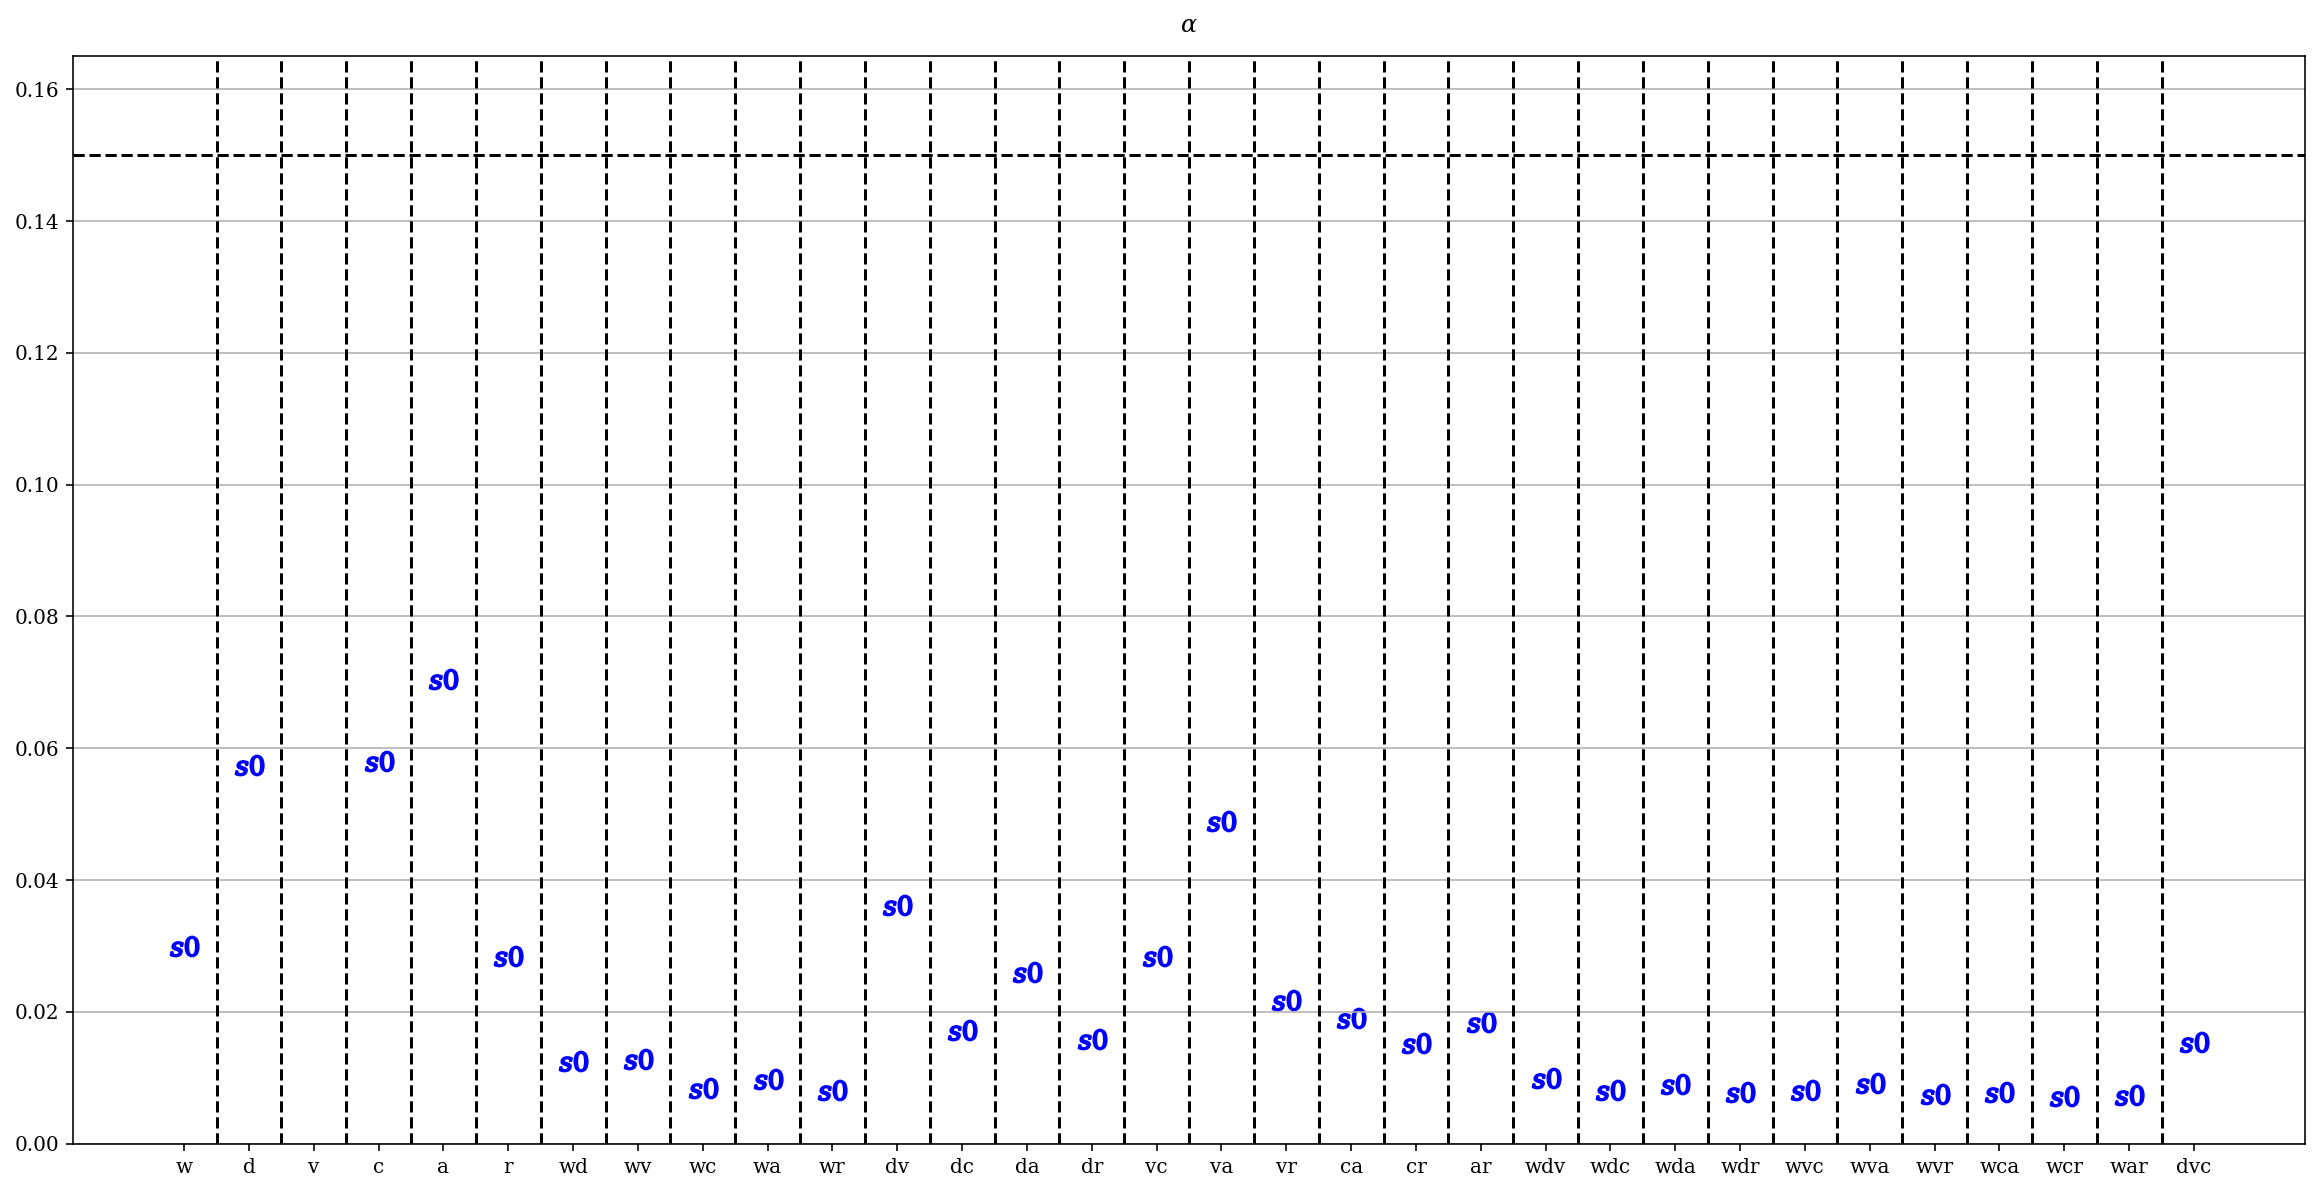

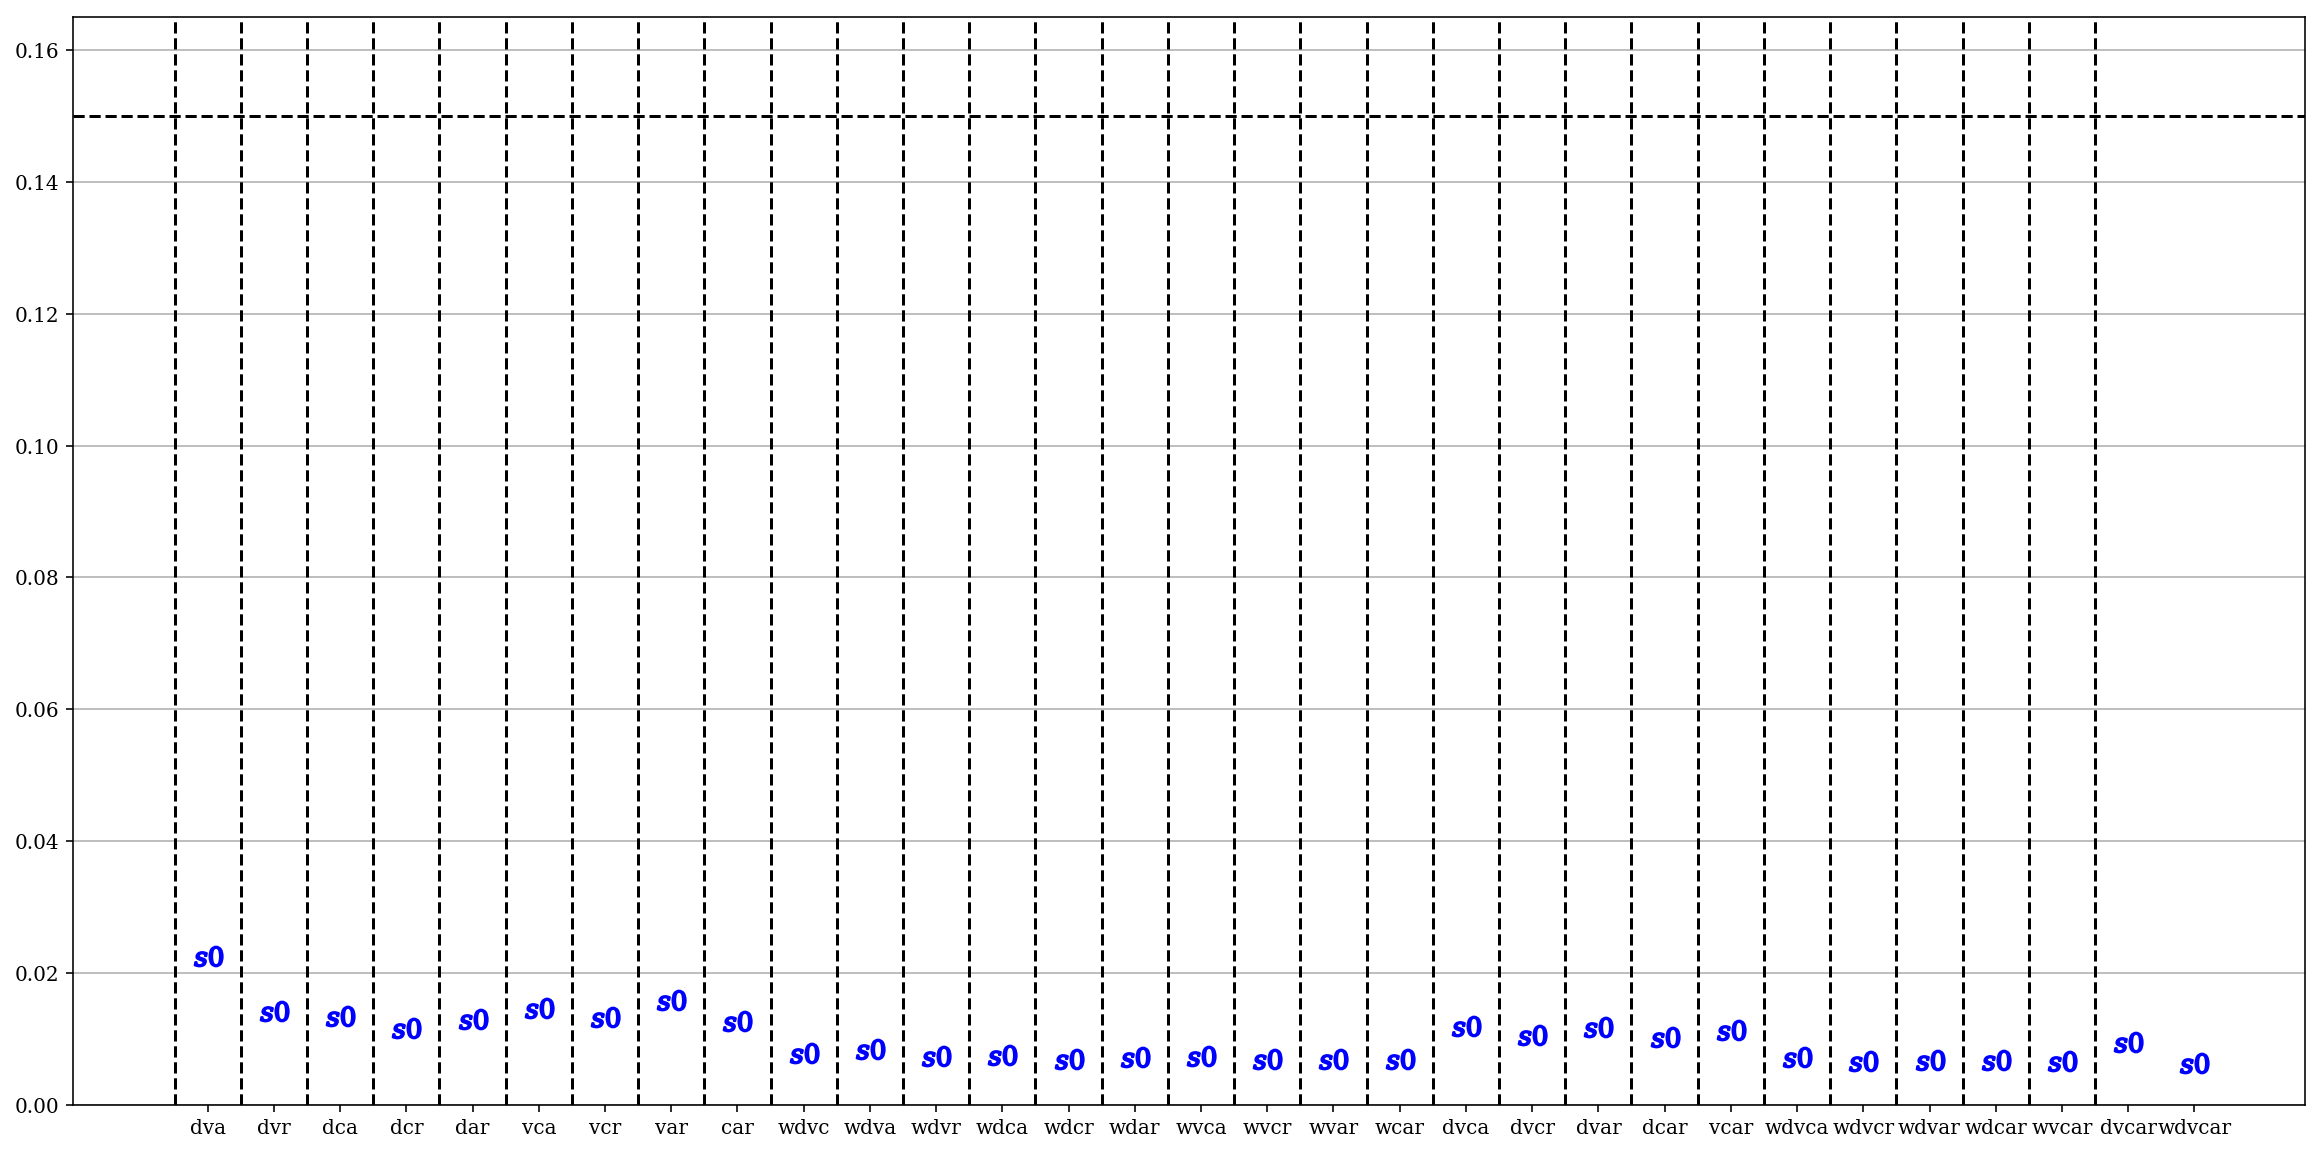

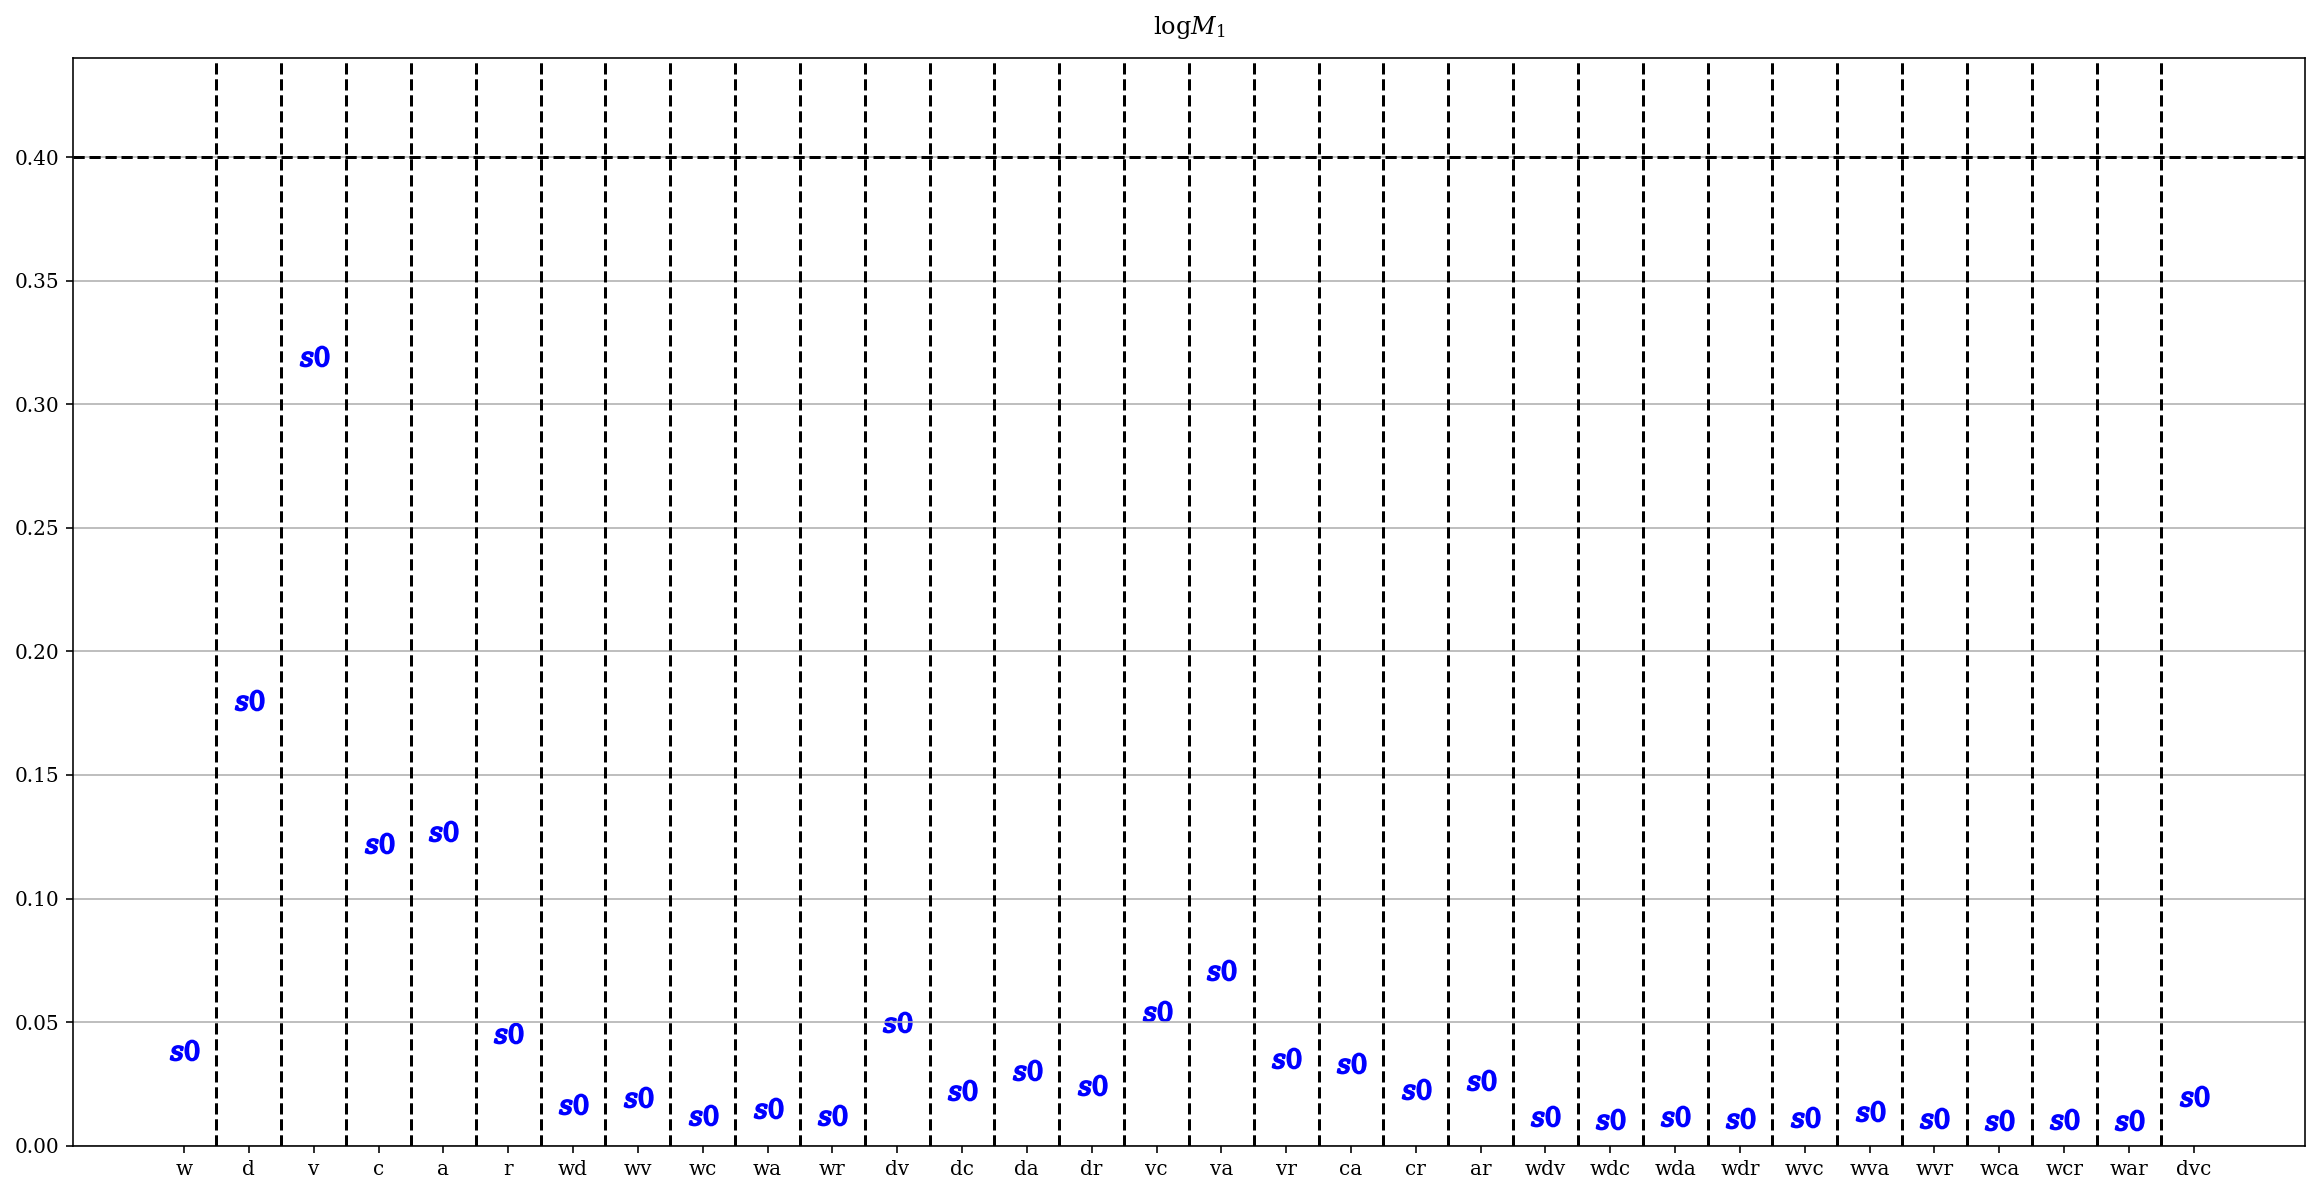

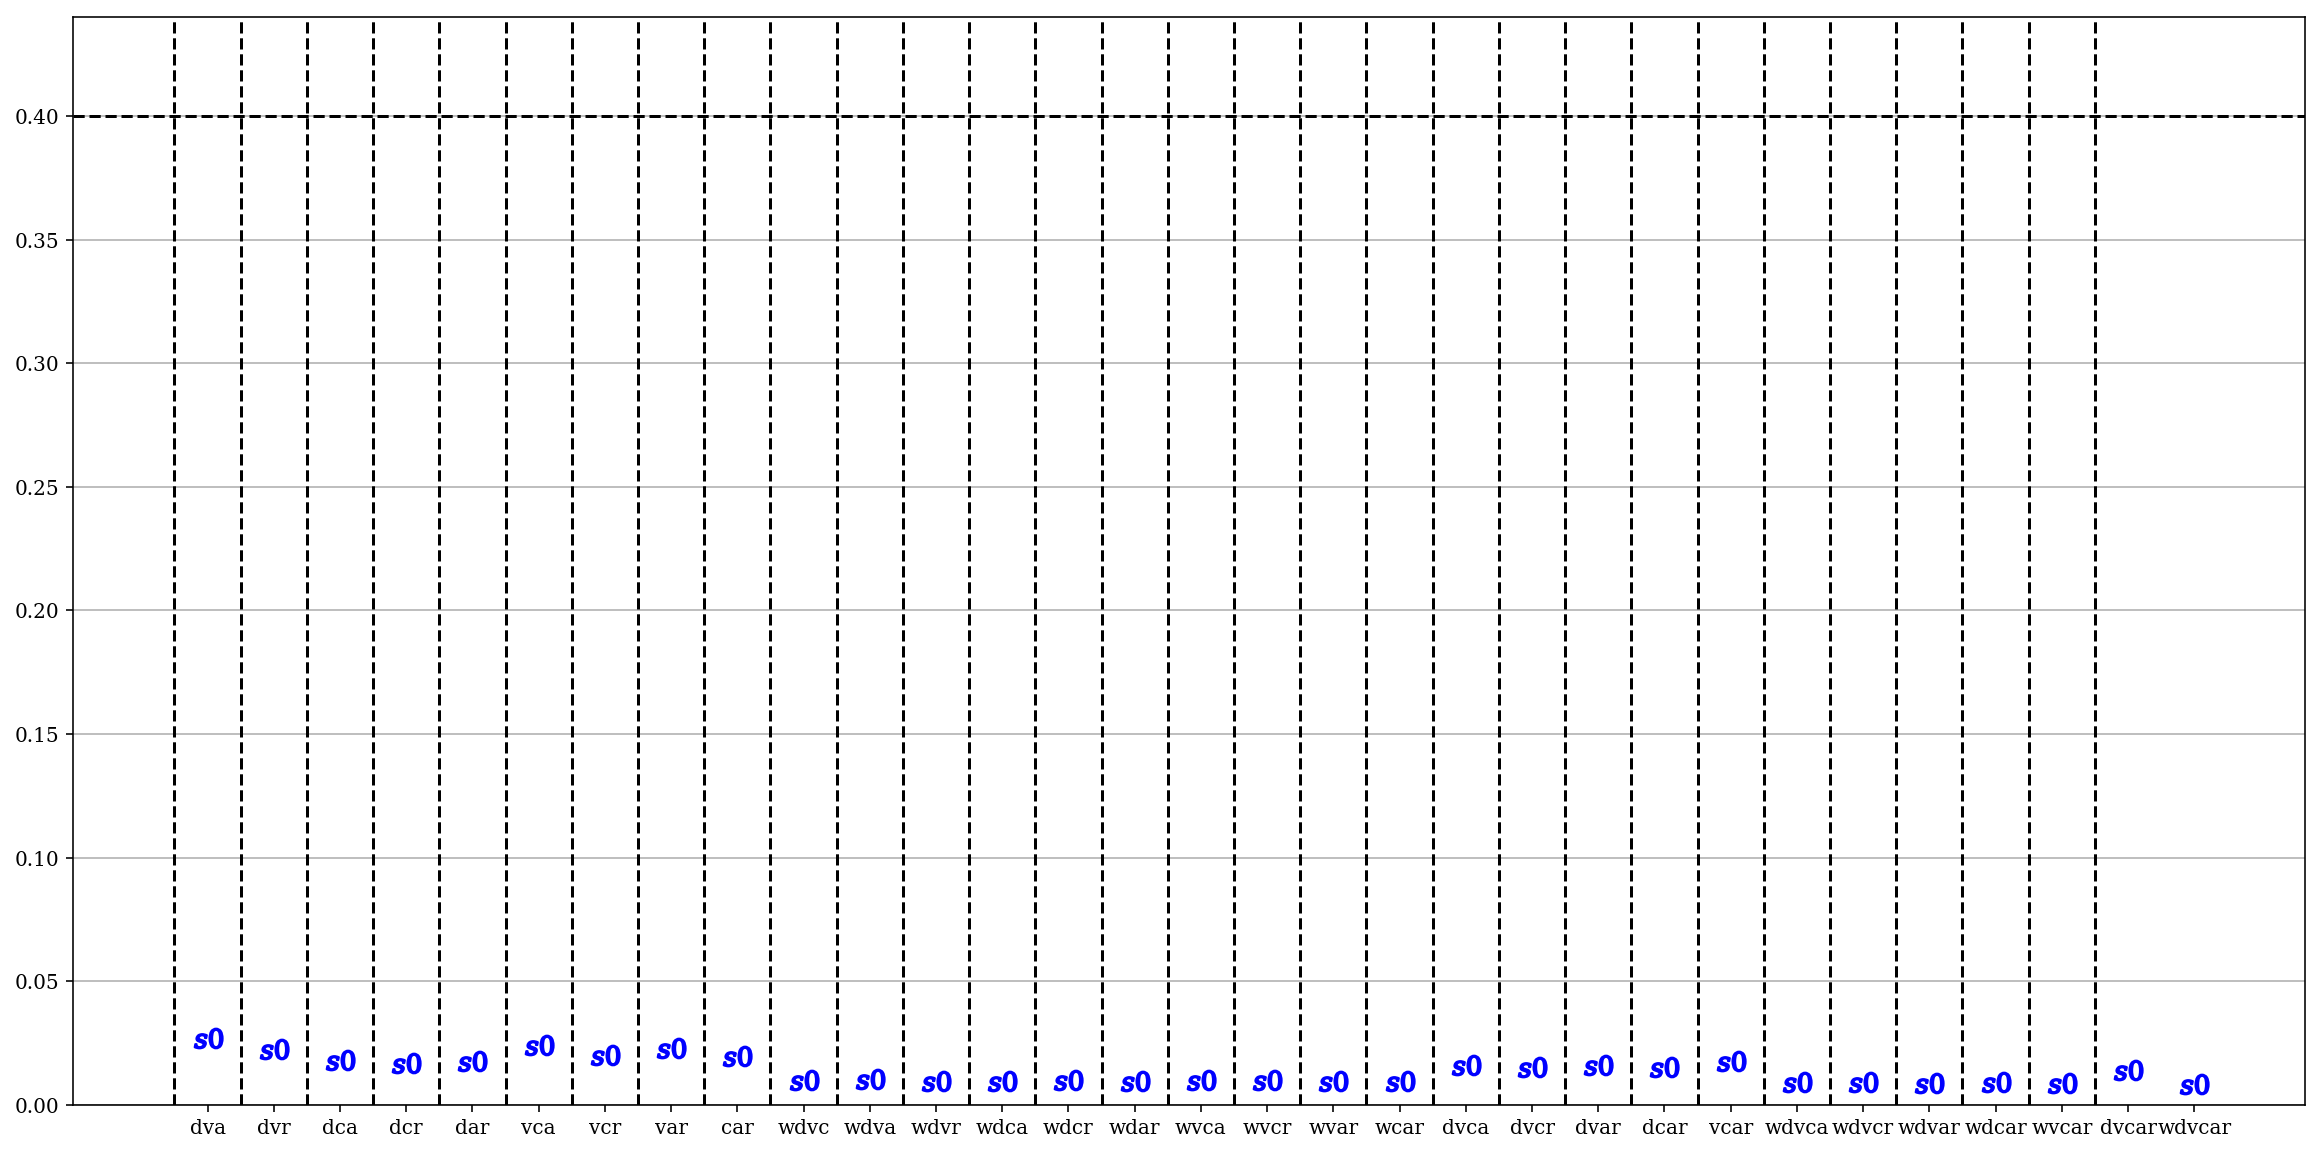

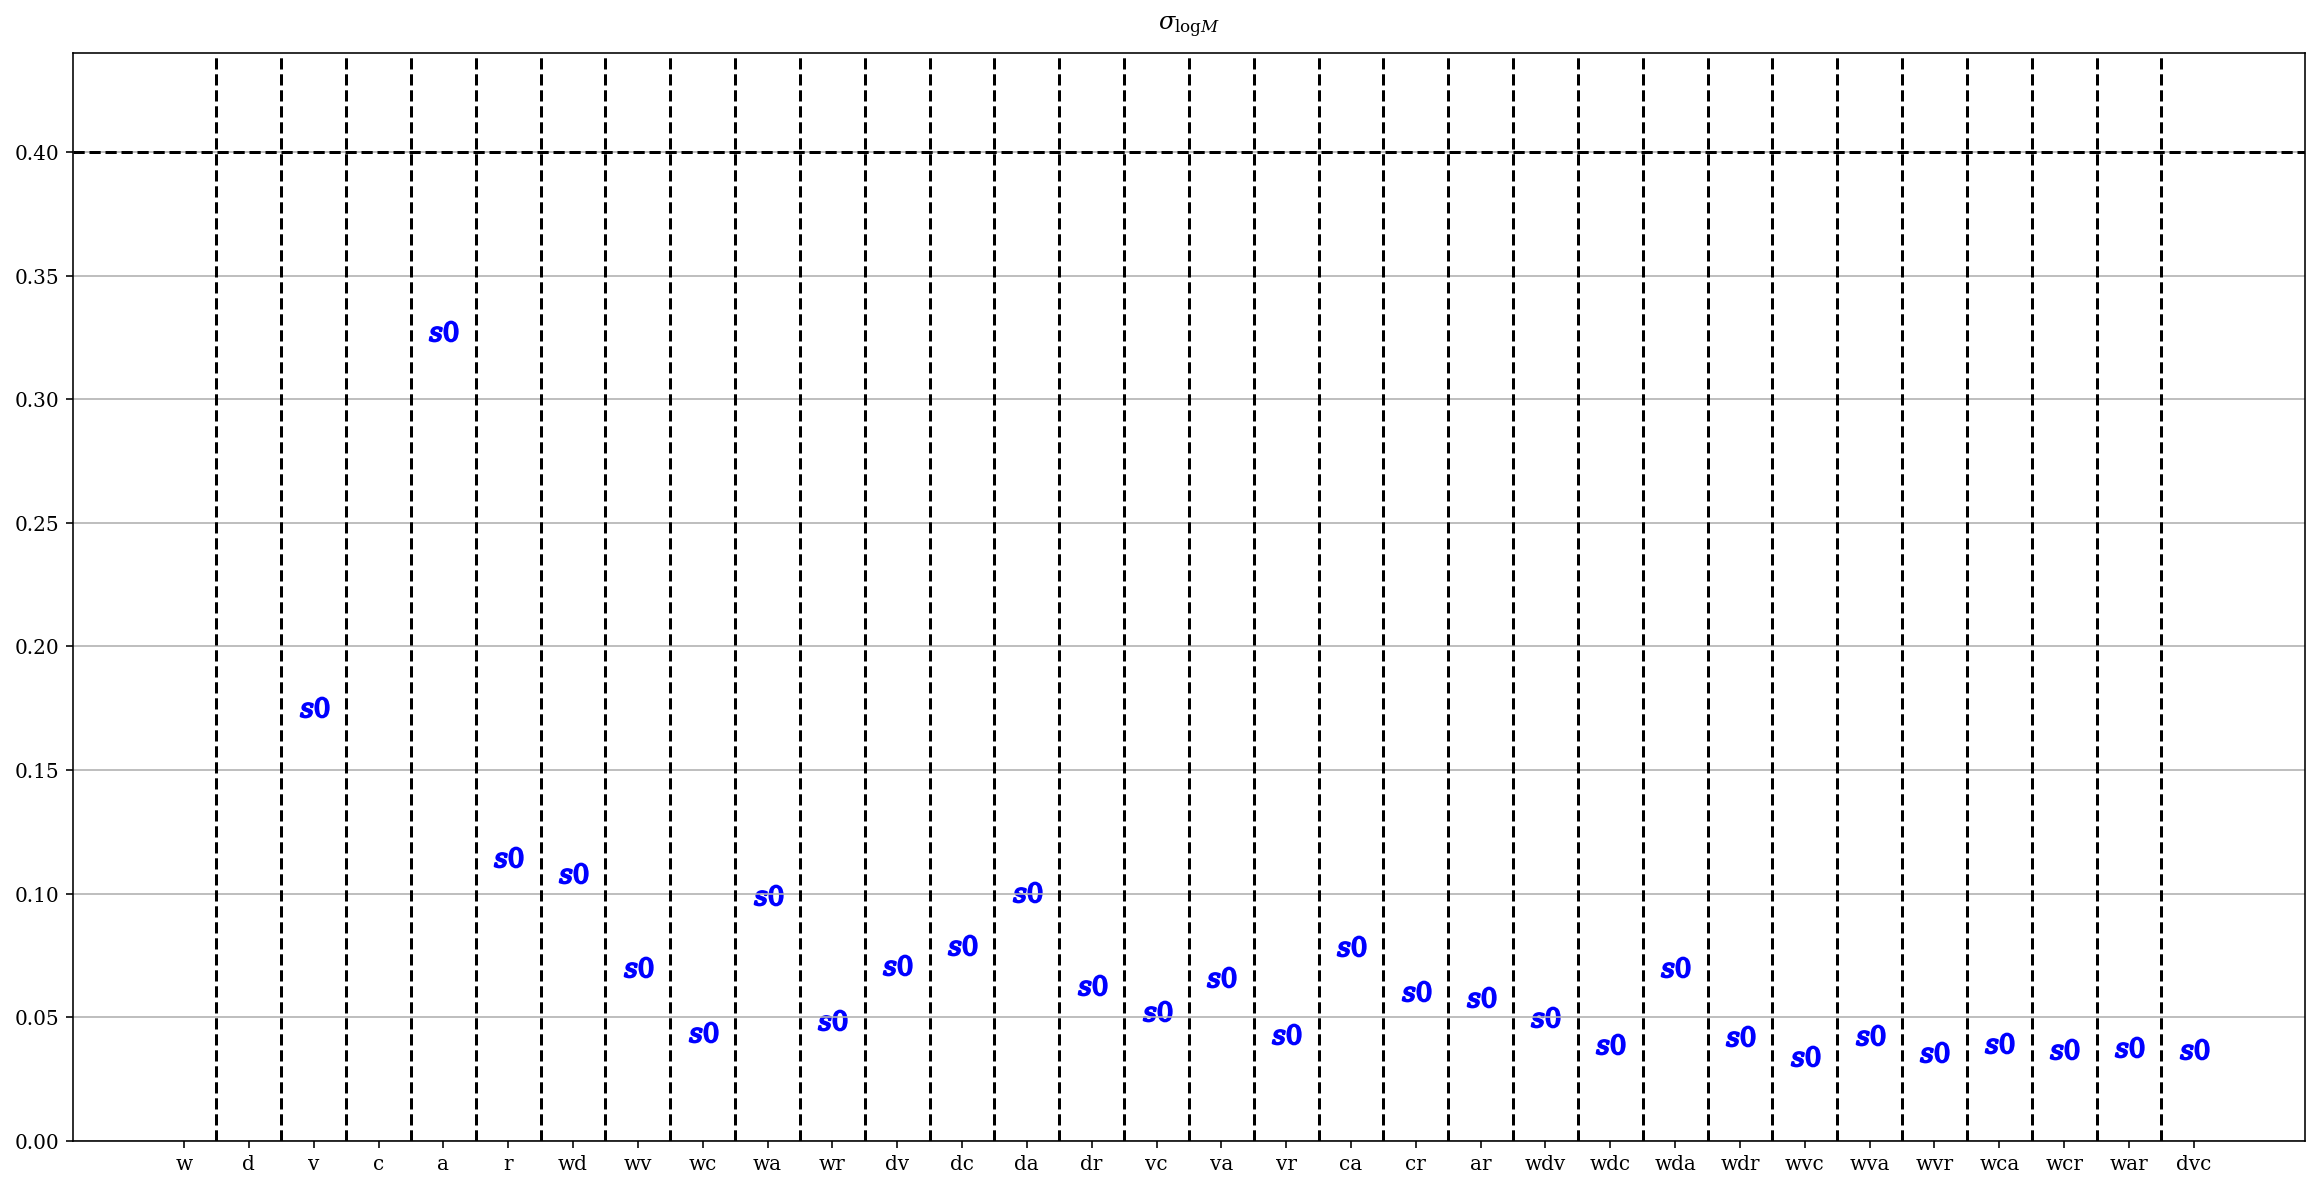

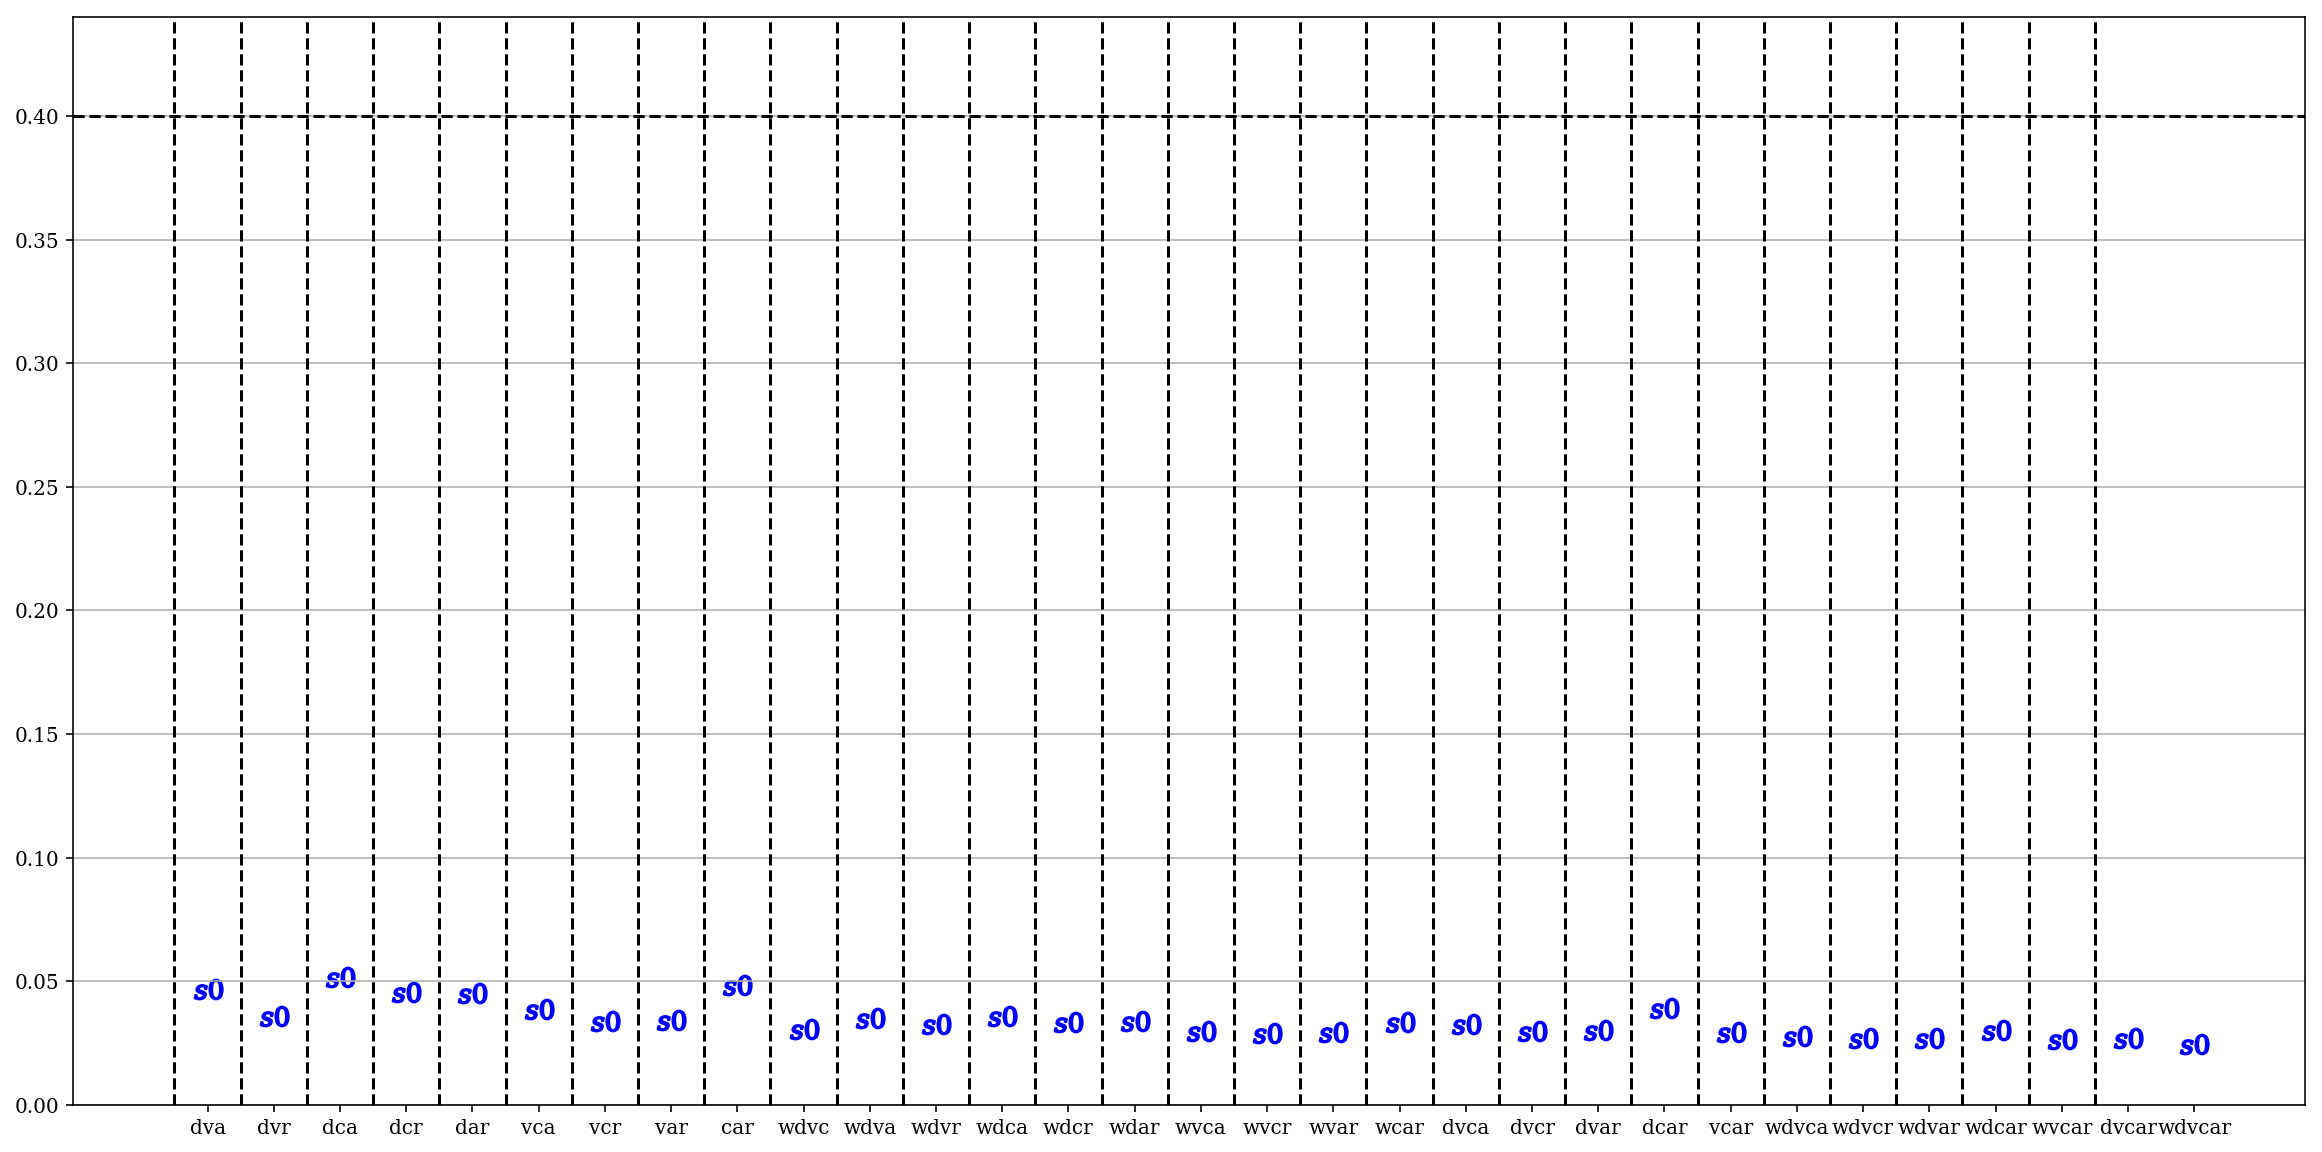

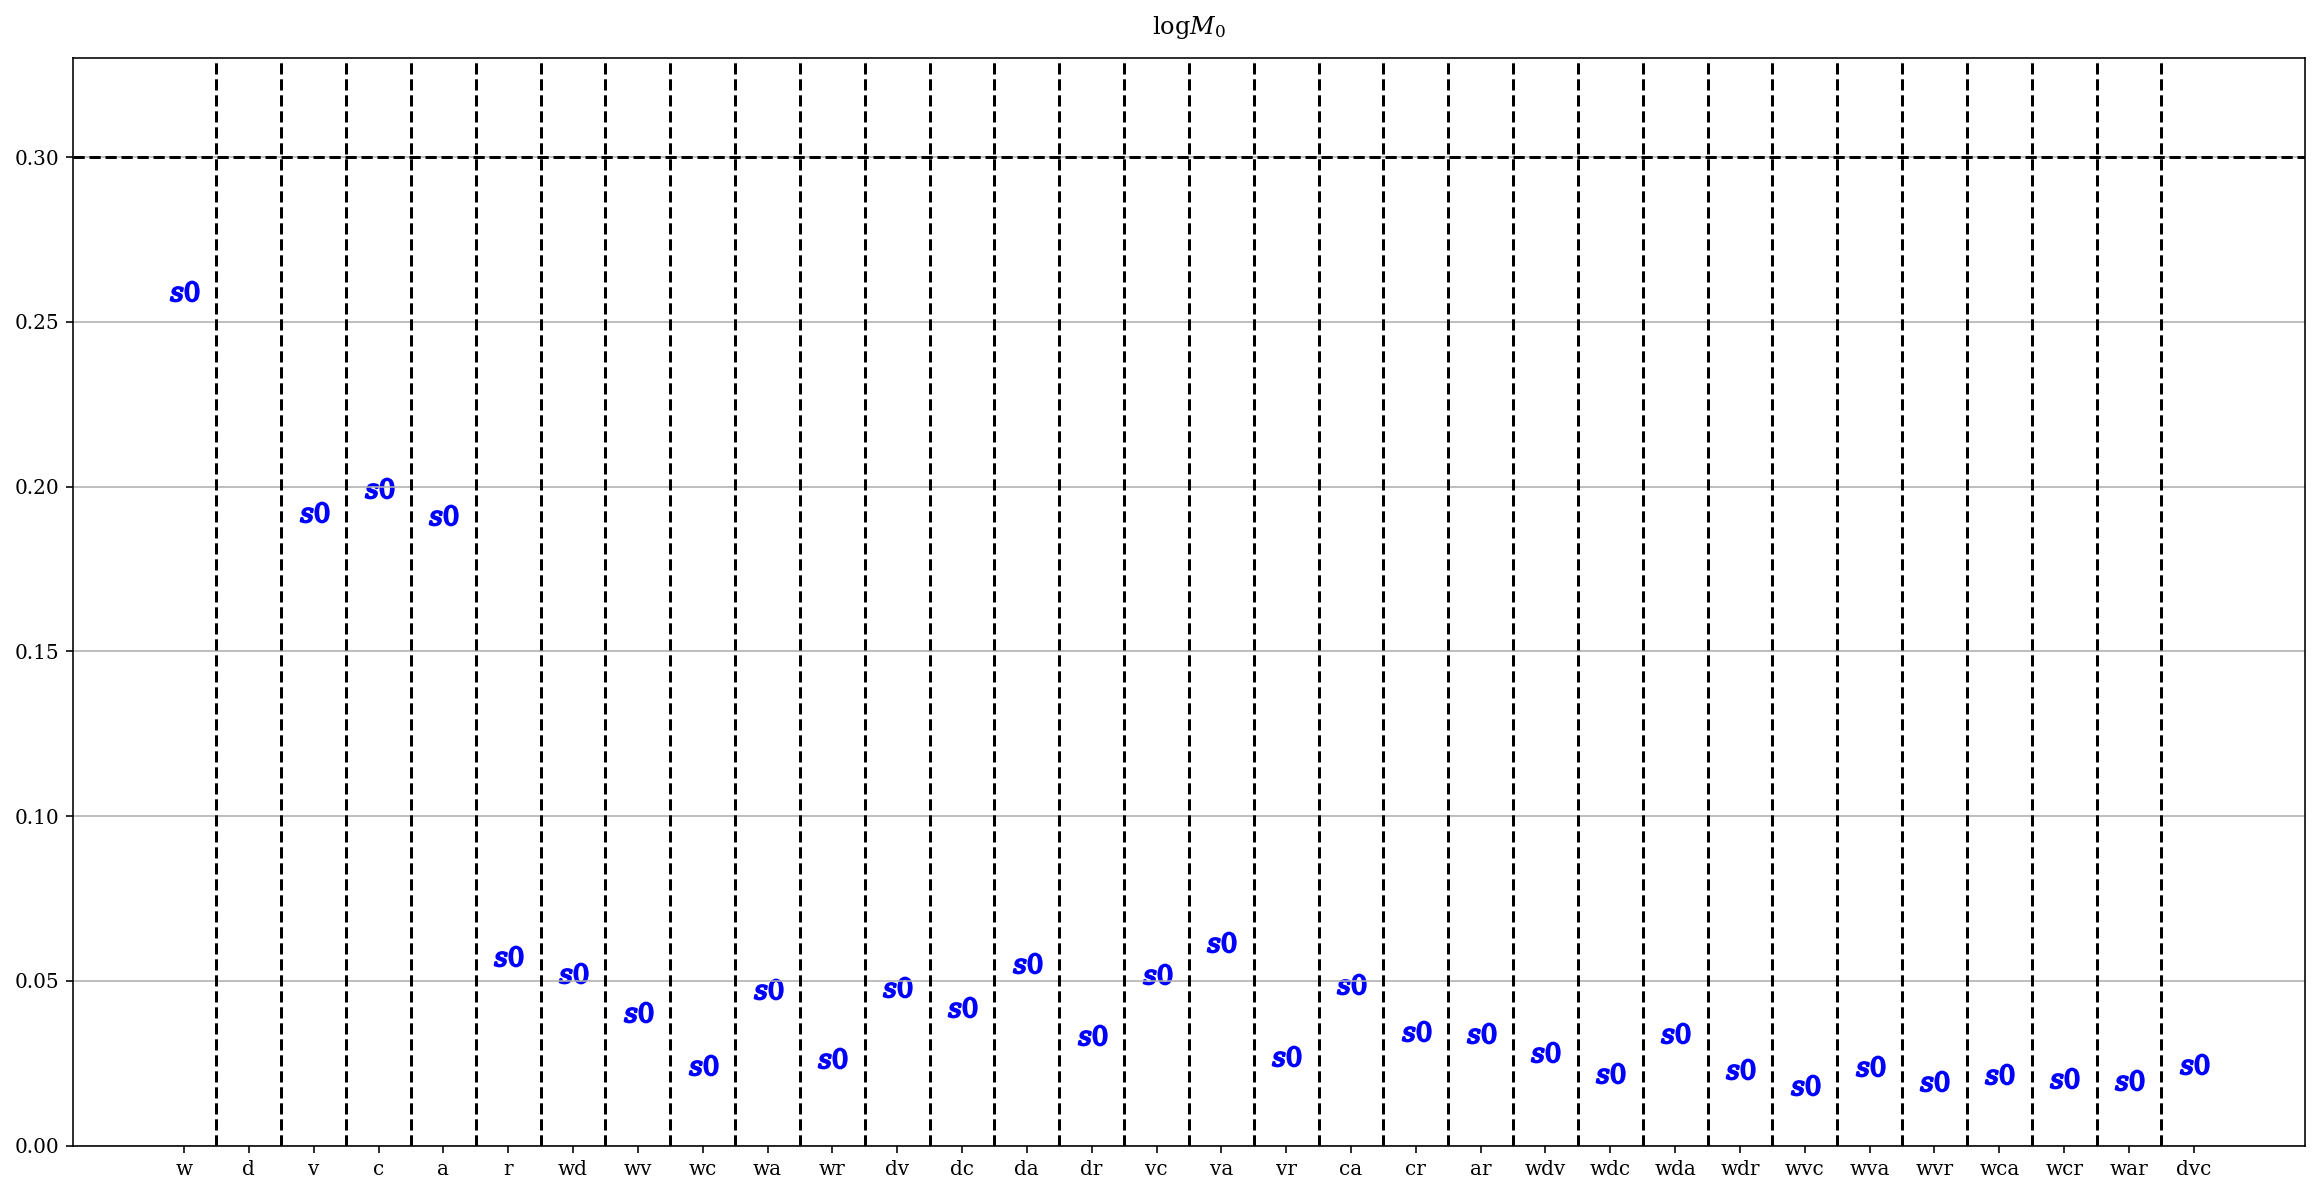

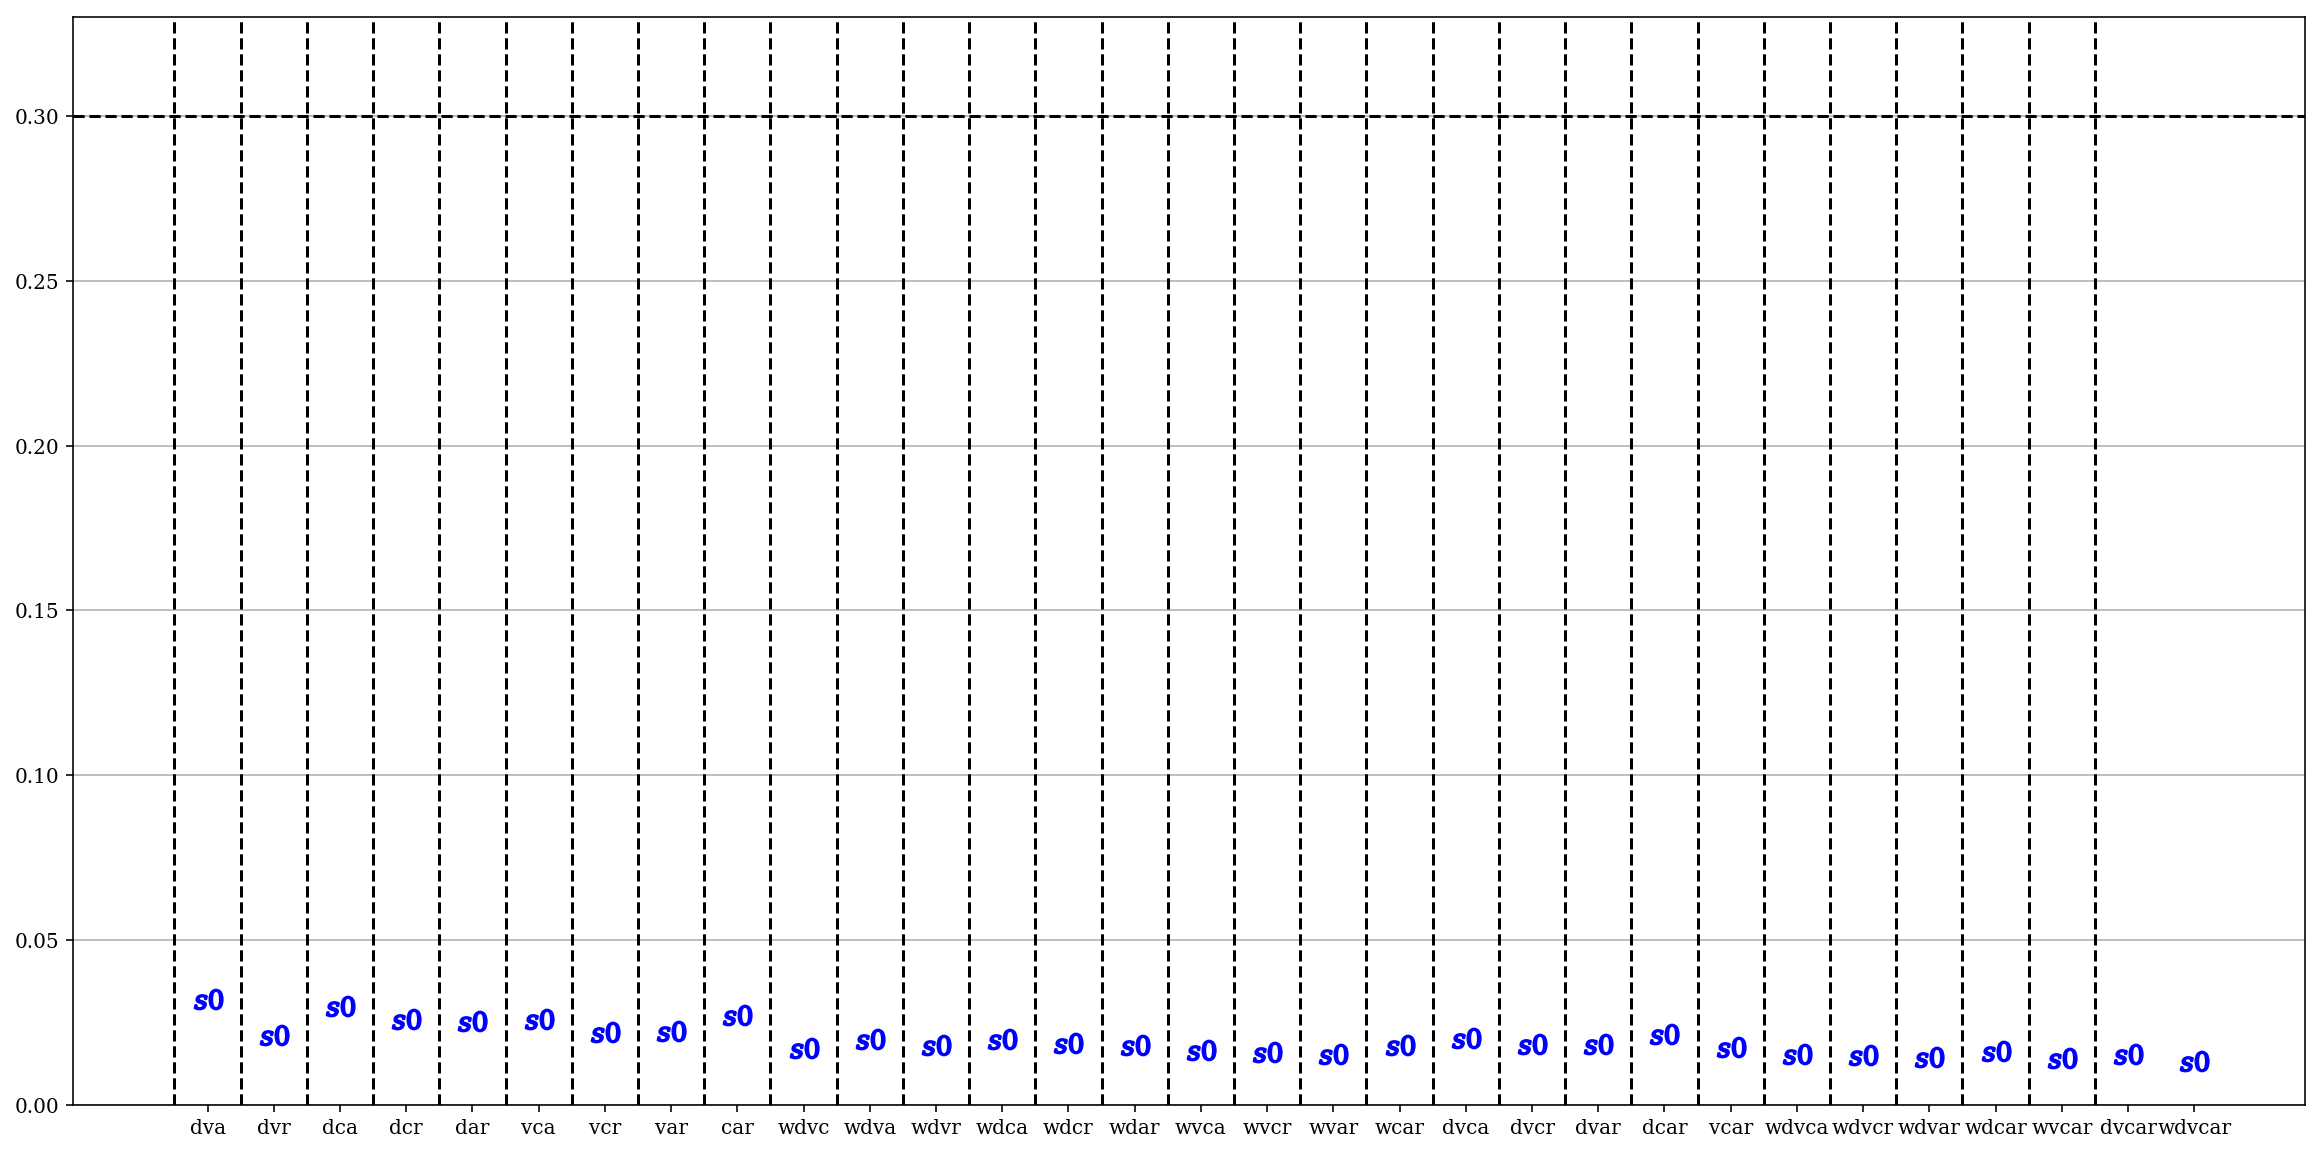

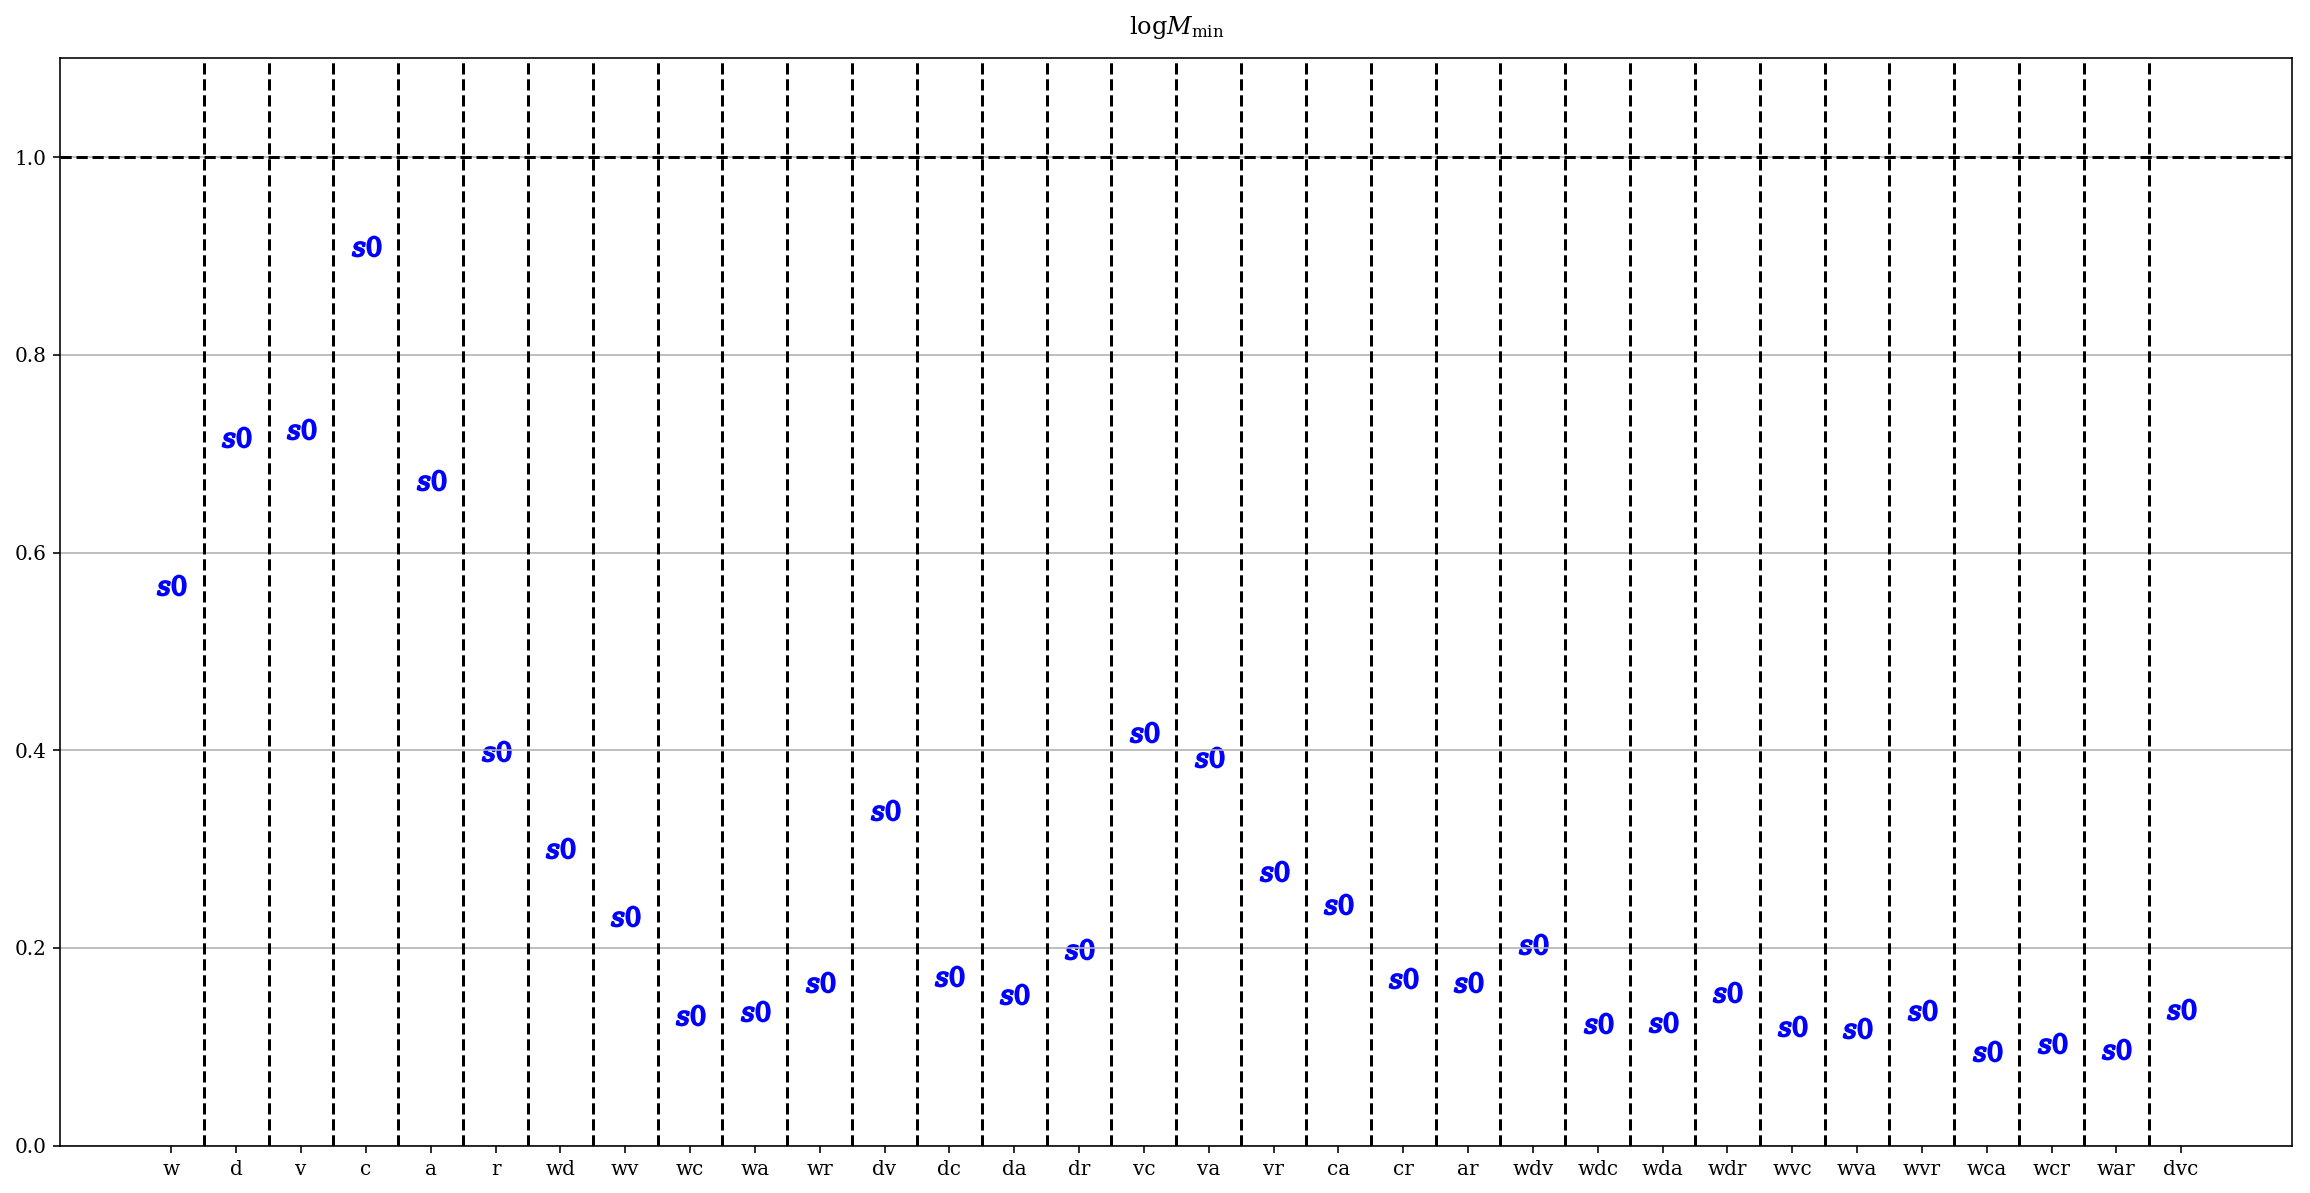

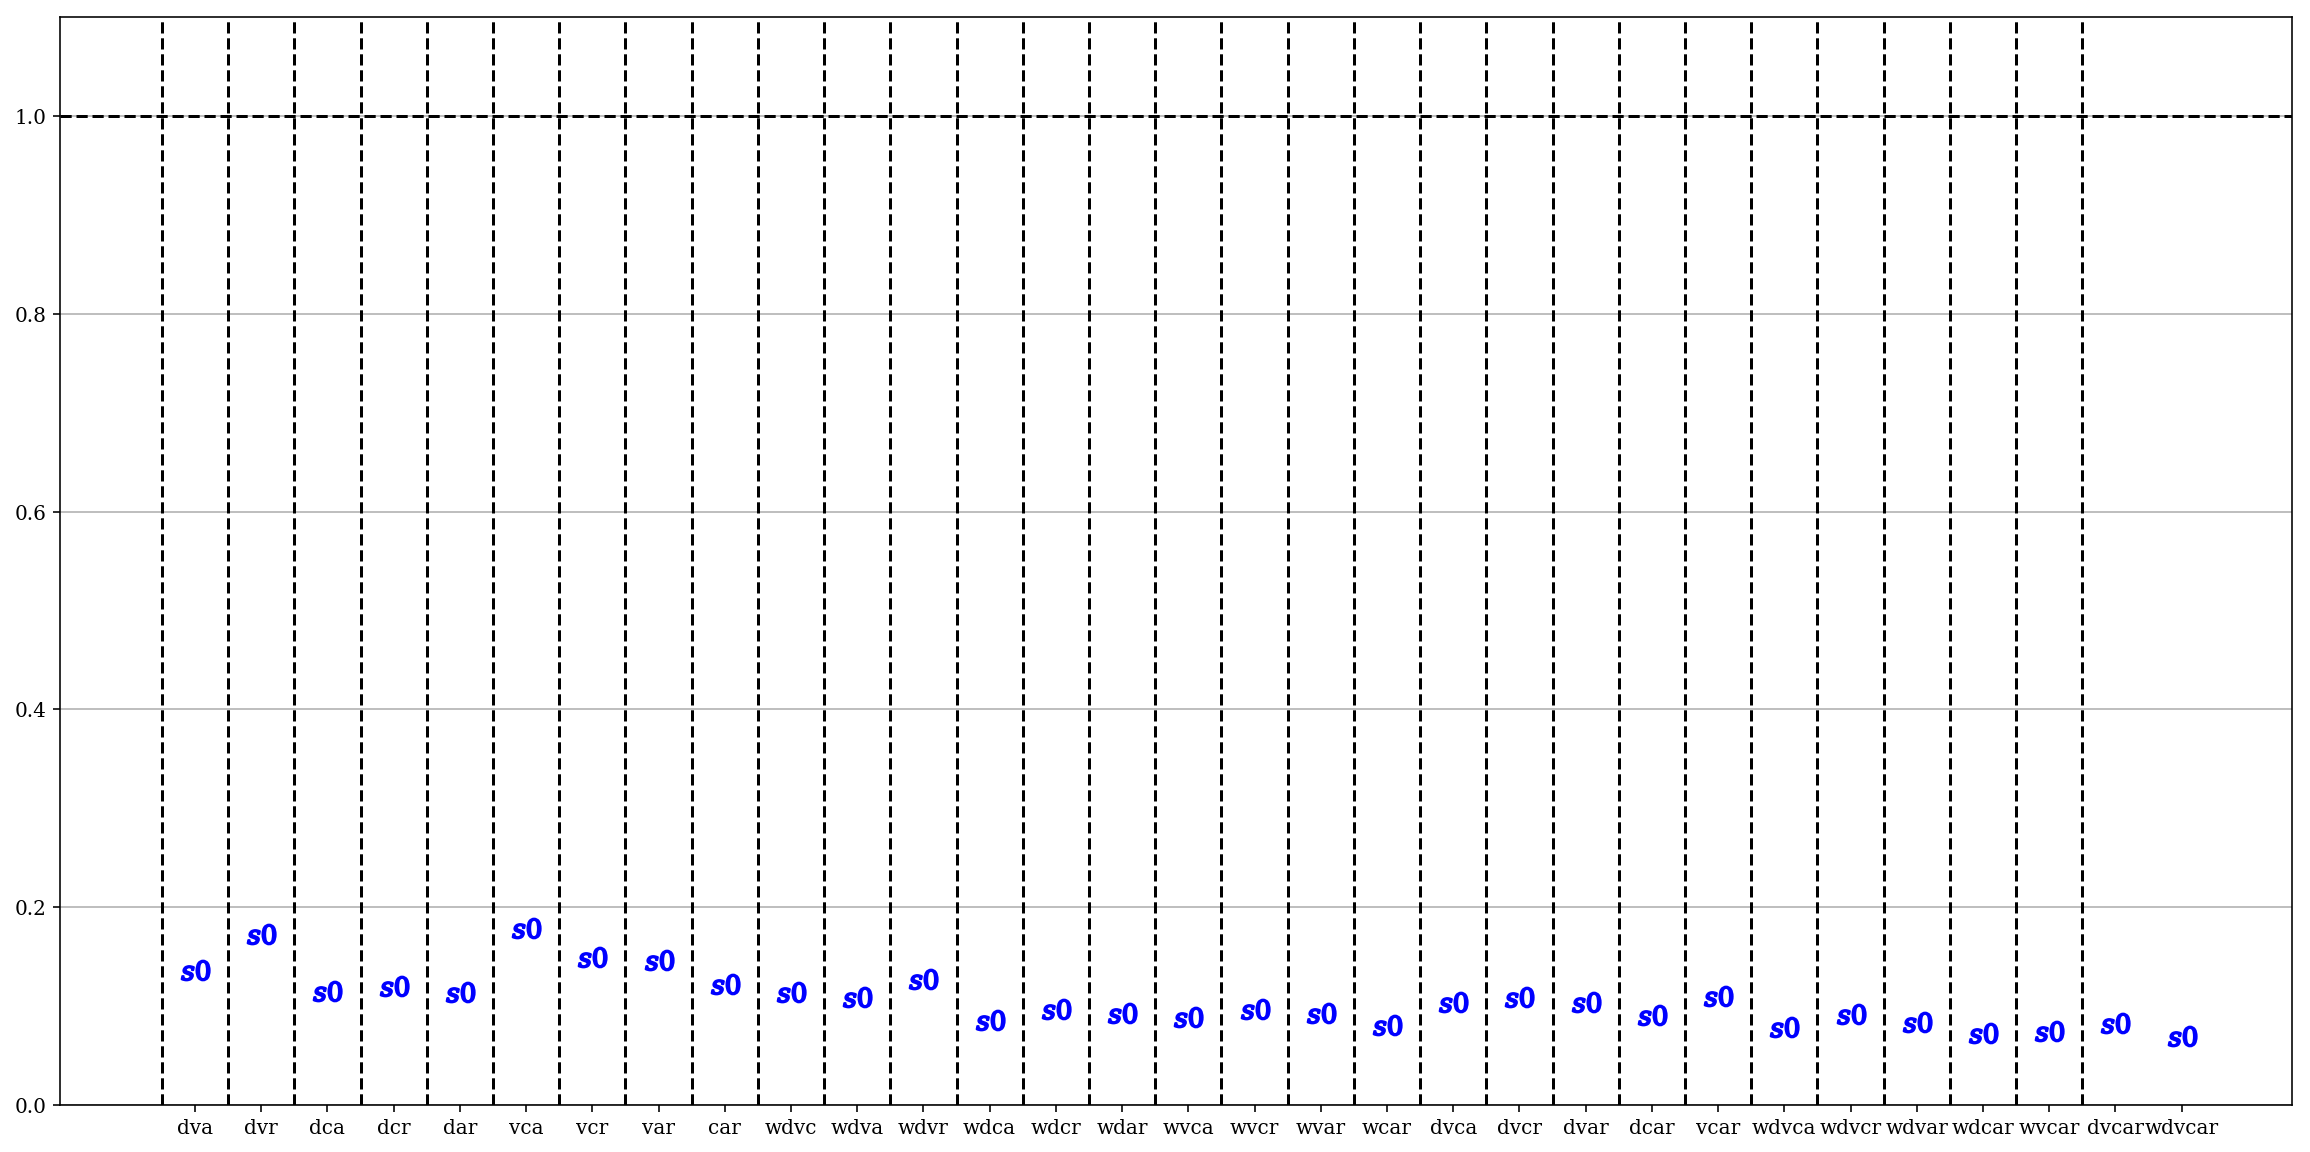

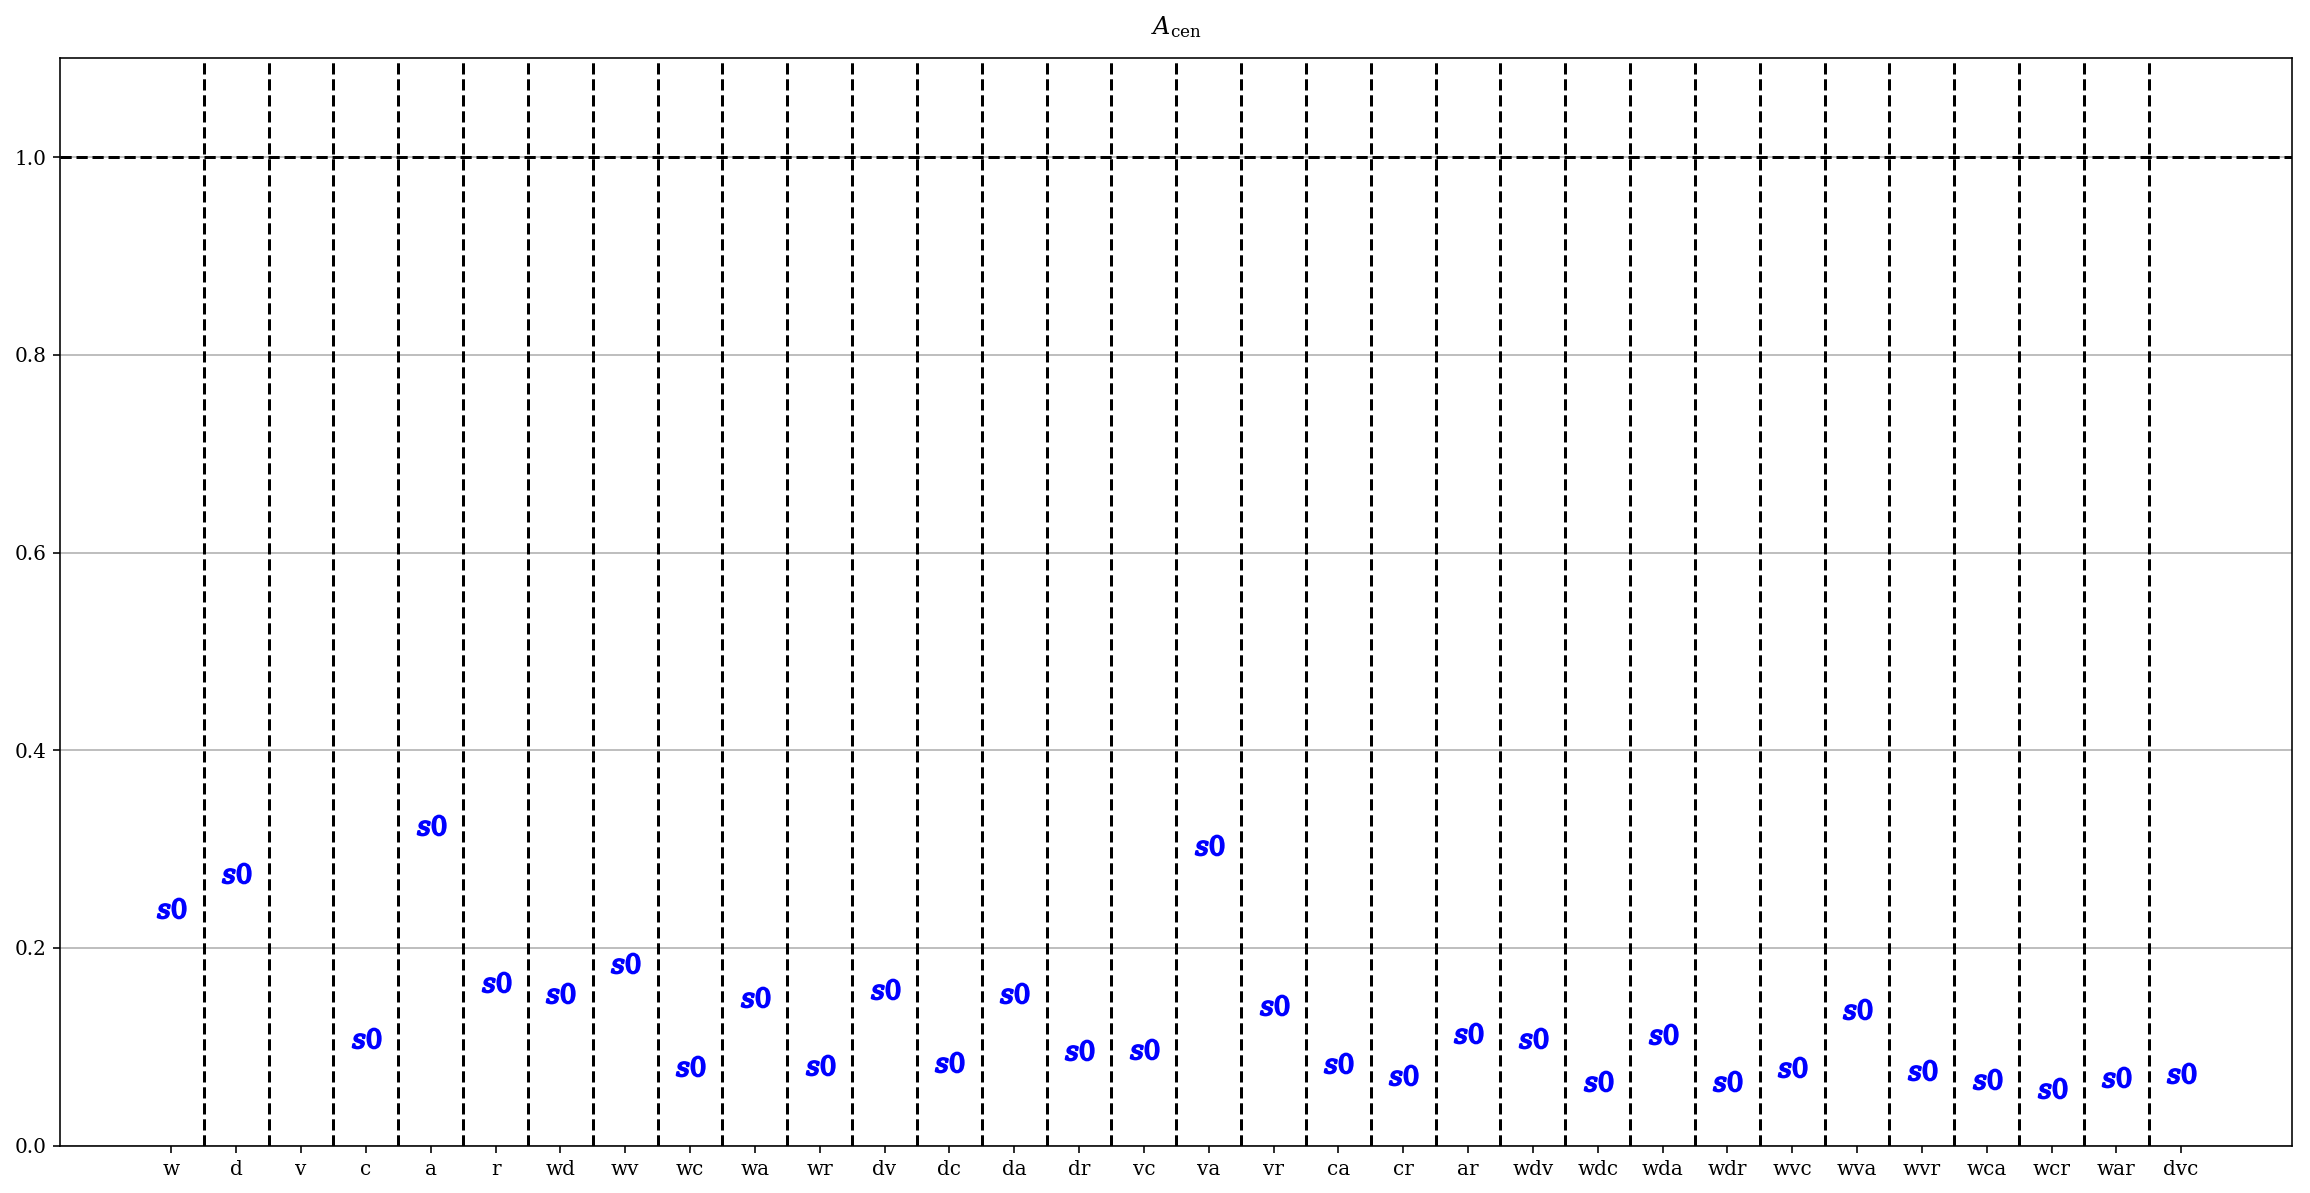

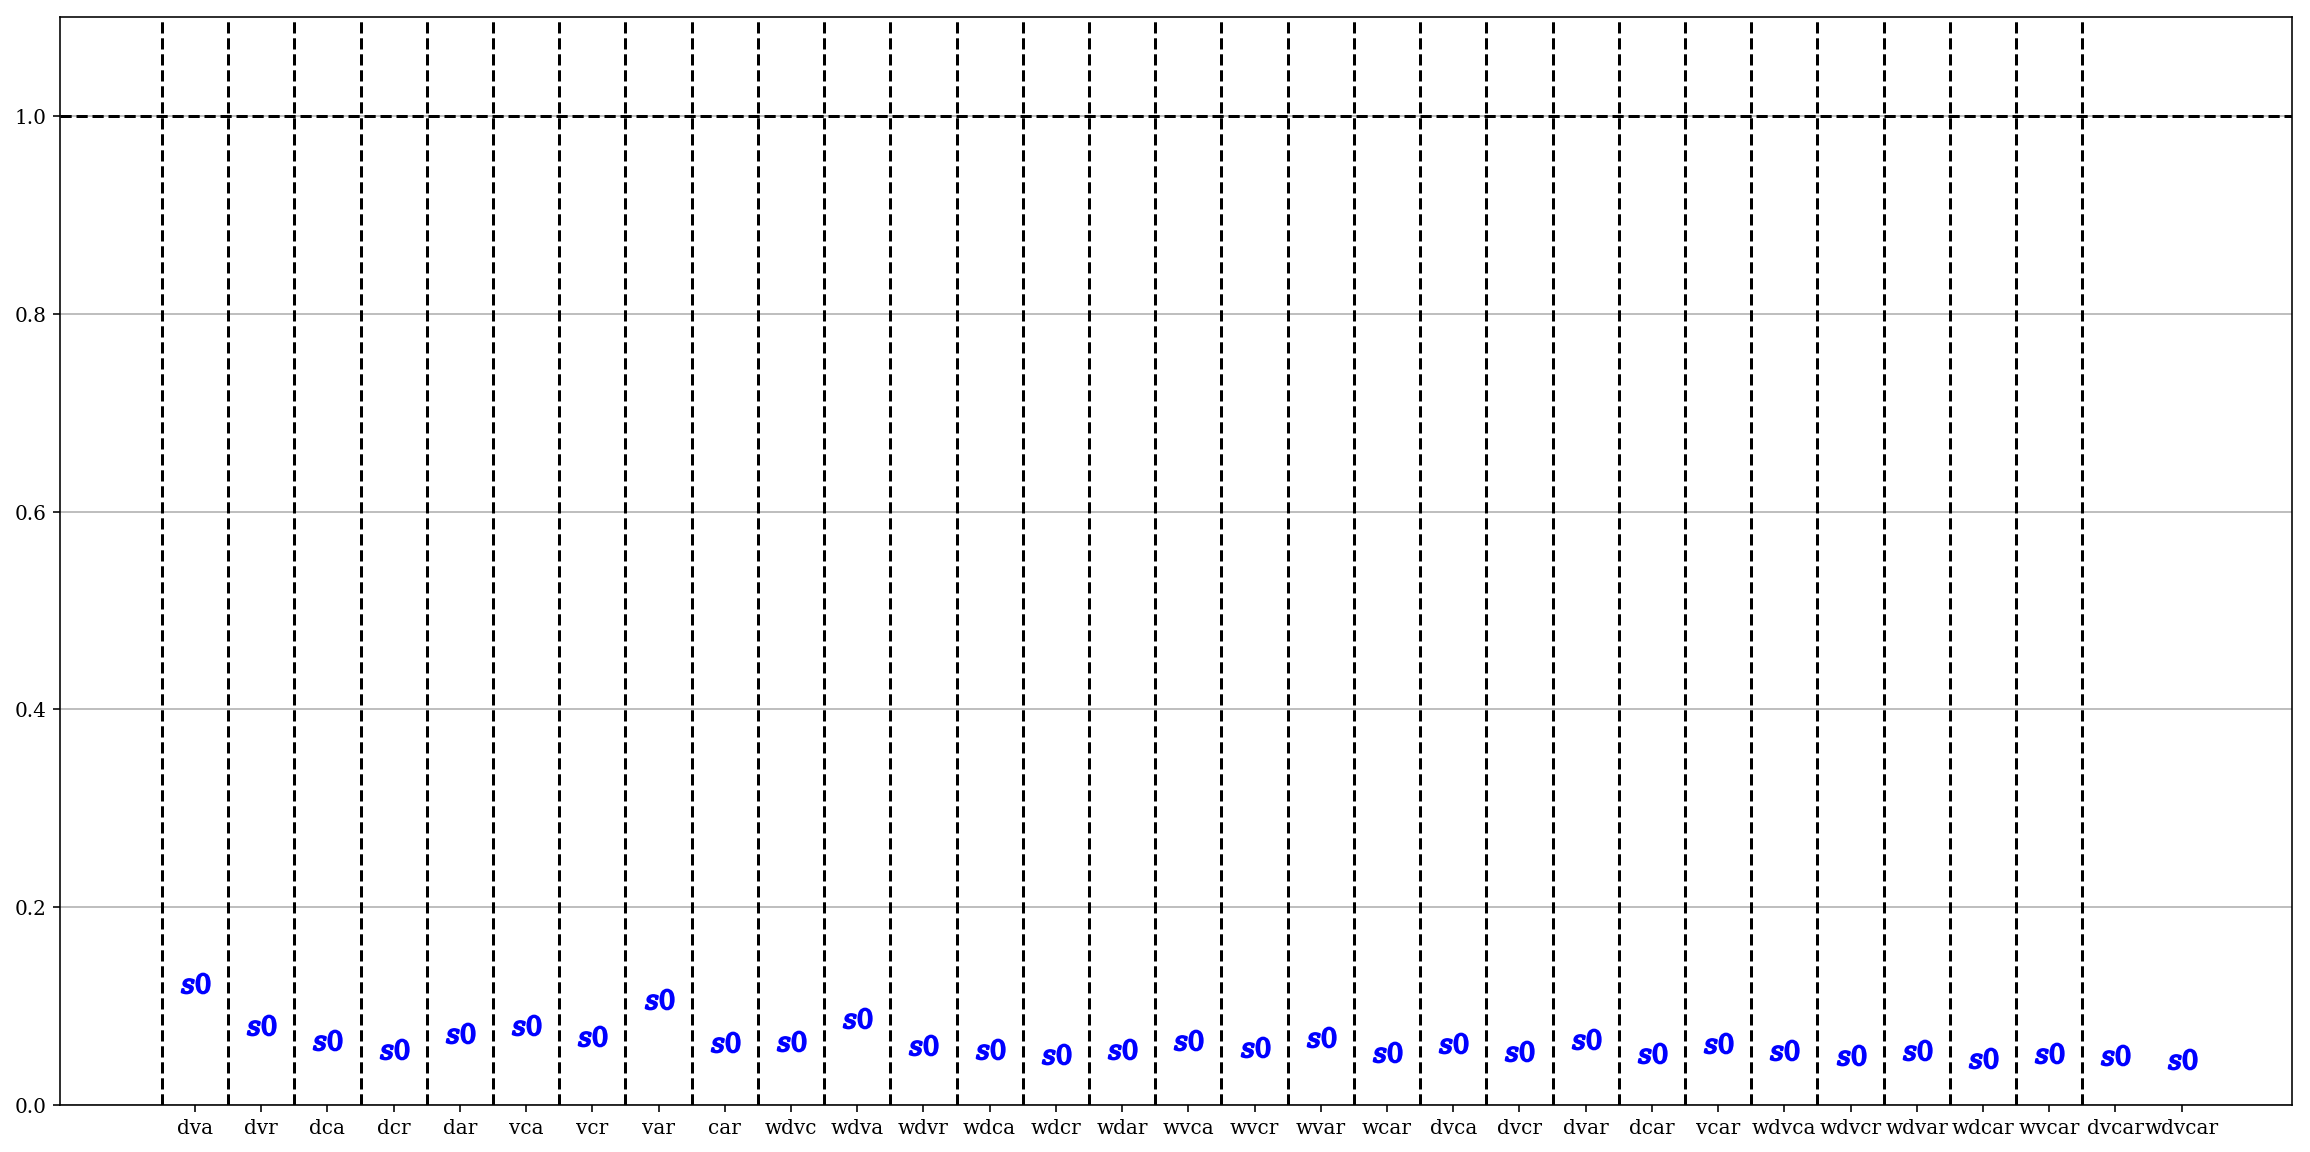

In [10]:
for i in range(6):
    #sa0 = np.array([alphas_cut_0[key][i]*oneside[i] for key in keylist])
    s0 = np.array([sigma_dict_19p5[key][i] for key in pf.keylist])
    #sa1 = np.array([alphas_cut_1[key][i]*oneside[i] for key in keylist])
    #s1 = np.array([sigma_cut_1[key][i] for key in keylist])
    #sa2 = np.array([alphas_cut_2[key][i]*oneside[i] for key in keylist])
    #s2 = np.array([sigma_cut_2[key][i] for key in keylist])
    #sa3 = np.array([alphas_cut_3[key][i]*oneside[i] for key in keylist])
    #s3 = np.array([sigma_cut_3[key][i] for key in keylist])
    #sa4 = np.array([alphas_cut_4[key][i]*oneside[i] for key in keylist])
    #s4 = np.array([sigma_cut_4[key][i] for key in keylist])
    plt.figure(figsize=(20,10))
    plt.axhline(oneside[i],c='k',ls='--')
    for j in range(31):
        plt.axvline(j+0.5,c='k',ls='--')
    #plt.scatter(range(32),sa0[:32],c='r',marker='$a0$',s=200)
    #plt.scatter(range(32),sa1[:32],c='r',marker='$a1$',s=200)
    #plt.scatter(range(32),sa2[:32],c='r',marker='$a2$',s=200)
    #plt.scatter(range(32),sa3[:32],c='r',marker='$a3$',s=200)
    #plt.scatter(range(32),sa4[:32],c='r',marker='$a4$',s=200)
    plt.scatter(range(32),s0[:32],c='b',marker='$s0$',s=200)
    #plt.scatter(range(32),s1[:32],c='b',marker='$s1$',s=200)
    #plt.scatter(range(32),s2[:32],c='b',marker='$s2$',s=200)
    #plt.scatter(range(32),s3[:32],c='b',marker='$s3$',s=200)
    #plt.scatter(range(32),s4[:32],c='b',marker='$s4$',s=200)
    plt.xticks(range(32),pf.keylist[:32])
    plt.ylim((0,1.1*oneside[i]))
    plt.grid(axis='y')
    plt.title(pf.param_list[i])
    
    plt.figure(figsize=(20,10))
    plt.axhline(oneside[i],c='k',ls='--')
    for j in range(31,61):
        plt.axvline(j+0.5,c='k',ls='--')
    #plt.scatter(range(32,63),sa0[32:],c='r',marker='$a0$',s=200)
    #plt.scatter(range(32,63),sa1[32:],c='r',marker='$a1$',s=200)
    #plt.scatter(range(32,63),sa2[32:],c='r',marker='$a2$',s=200)
    #plt.scatter(range(32,63),sa3[32:],c='r',marker='$a3$',s=200)
    #plt.scatter(range(32,63),sa4[32:],c='r',marker='$a4$',s=200)
    plt.scatter(range(32,63),s0[32:],c='b',marker='$s0$',s=200)
    #plt.scatter(range(32,63),s1[32:],c='b',marker='$s1$',s=200)
    #plt.scatter(range(32,63),s2[32:],c='b',marker='$s2$',s=200)
    #plt.scatter(range(32,63),s3[32:],c='b',marker='$s3$',s=200)
    #plt.scatter(range(32,63),s4[32:],c='b',marker='$s4$',s=200)
    plt.xticks(range(32,63),pf.keylist[32:])
    plt.ylim((0,1.1*oneside[i]))
    plt.grid(axis='y')

In [10]:
dfdp_min1 = np.zeros((7,180))
for i in range(7):
    for j in range(180):
        dfdp_min1[i,j] = pf.locfit_deriv_singley(average_curves[Nparam*i:Nparam*i+Nparam], alpha, pertparam[i], p0[i])

In [11]:
dfdp_cut = pf.cut_by_func_1D(dfdp_all,axis=1,funcidx={'w':range(30),'d':range(30,60),'v':range(60,90),\
                                           'c':range(90,120),'a':range(120,150),'r':range(150,180)})
fisher_cut = pf.apply_to_dict(pf.calc_fisher,dfdp_cut,invcov_cut)
postcov_cut = pf.apply_to_dict(np.linalg.inv,fisher_cut)
sigma_cut = pf.apply_to_dict(pf.calc_1sigma,fisher_cut)

In [12]:
sigma_cut_19p0 = copy.deepcopy(sigma_cut)
%store sigma_cut_19p0
postcov_cut_19p0 = copy.deepcopy(postcov_cut)
%store postcov_cut_19p0

Stored 'sigma_cut_19p0' (dict)
Stored 'postcov_cut_19p0' (dict)


In [14]:
dfdp_19p0 = copy.deepcopy(dfdp_all)
%store dfdp_19p0

Stored 'dfdp_19p0' (ndarray)


In [40]:
param_list = [r'$\alpha$', r'$\log{M_\mathrm{1}}$', r'$\sigma_{\log{M}}$', r'$\log{M_\mathrm{0}}$', r'$\log{M_{\rm{min}}}$',\
              r'$A_{\rm{cen}}$', r'$A_{\rm{sat}}$']

r_wp = np.logspace(-1,1.5,30)
r_wp = (r_wp[1:]+r_wp[:-1])/2.

r_ds = np.logspace(-1,1.5,31)
r_ds = np.sqrt(0.5*(r_ds[1:]**2 + r_ds[:-1]**2))

r_vpf = np.logspace(0,1,30)

cic_bin = np.concatenate([np.arange(10),np.around(np.logspace(1,np.log10(150),30-10)).astype(np.int)])
cia_bin = np.concatenate([np.arange(10),np.around(np.logspace(1,np.log10(200),30-10)).astype(np.int)])

ratio_bin = np.linspace(0,1,31)

obs_list = [r'$n_{\mathrm{gal}}$',]+\
            list([r'$w_{\mathrm{p}}(r_{\mathrm{p}}= %.2f h^{-1}\mathrm{Mpc})$'%r for r in r_wp])+\
            list([r'$\Delta \Sigma(r_{\mathrm{p}}=%.2f h^{-1}\mathrm{Mpc})$'%r for r in r_ds])+\
            list([r'$\mathrm{VPF}(r=%.2f h^{-1}\mathrm{Mpc})$'%r for r in r_vpf])+\
            list([r'$P(N_{\mathrm{CIC}}=%d)$'%i for i in range(10)])+\
            list([r'$P(%d\leq N_{\mathrm{CIC}}<%d)$'%(cic_bin[i],cic_bin[i+1]) for i in range(10,29)])+\
            [r'$P(N_{\mathrm{CIC}} \geq %d)$'%cic_bin[-1],]+\
            list([r'$P(N_{\mathrm{CIA}}=%d)$'%i for i in range(10)])+\
            list([r'$P(%d\leq N_{\mathrm{CIA}}<%d)$'%(cia_bin[i],cia_bin[i+1]) for i in range(10,29)])+\
            [r'$P(N_{\mathrm{CIA}} \geq %d)$'%cia_bin[-1],]+\
            list([r'$P(%.3f<N_2/N_5<%.3f)$'%(ratio_bin[i],ratio_bin[i+1]) for i in range(30)])

def plot_fi_pj(i,j,pertfunc_dict,gcv_alphas,dfdp=None,save=0):
    fig = plt.figure(figsize=(13,10))
    plt.xlabel(param_list[i],fontsize=30)
    plt.ylabel(obs_list[j],fontsize=30)
    plt.plot(pertparam[i],average_curves[200*i:200*i+200,j],'b-',label='averaged curve')
    if dfdp==None:
        dfdp = pf.locfit_deriv_singley(average_curves[200*i:200*i+200,j],gcv_alphas[i,j],pertparam[i],p0[i])
    plt.plot(pertparam[i],(pertparam[i]-p0[i])*dfdp+average_curves[200*i+100,j],'b--',lw=2,label='fit with smoothing from GCV')
    for k in range(5):
        plt.plot(pertparam[i],(pertparam[i]-p0[i])*pf.locfit_deriv_singley(average_curves[200*i:200*i+200,j],k*0.2+0.2,pertparam[i],p0[i])+average_curves[200*i+100,j],':',c=cm.Reds(50+50*k),lw=1)
    plt.axvline(p0[i],c='k',ls='--')
    plt.axvspan(p0[i]-gcv_alphas[i,j]*oneside[i],p0[i]+gcv_alphas[i,j]*oneside[i],color='b',alpha=0.1,label='smoothing scale from GCV')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(frameon=False,fontsize=20)
    if save:
        fig.savefig('Fit_alphas_19p0/'+'p'+str(i)+'_f'+str(j)+'.png')
        plt.close(fig)
    return dfdp

In [42]:
for i in range(7):
    for j in range(180):
        plot_fi_pj(i,j,pertfunc_dict,gcv_alphas,save=1)

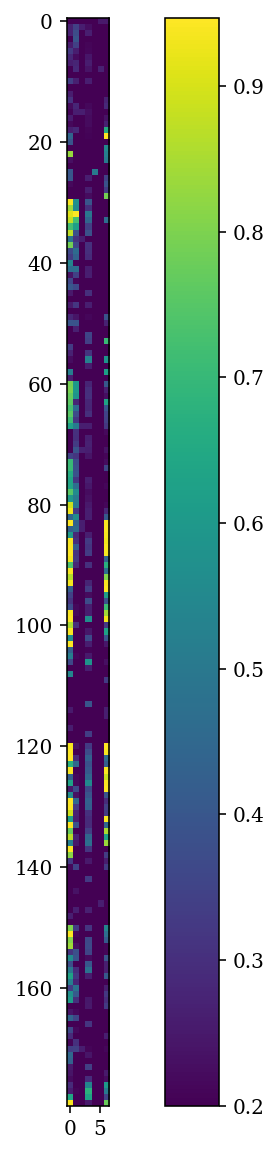

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(gcv_alphas.T)
plt.colorbar()

In [10]:
alphas_cut_0 = dict(zip([key for key in func_cut.keys()],np.ones((63,7))))
locfit_cut = pf.apply_to_dict(pf.locfit_comb,func_cut,alphas_cut_0,xs=pertparam,x0s=p0)
fisher_cut = pf.apply_to_dict(pf.calc_fisher,locfit_cut,invcov_cut)
sigma_cut_0 = pf.apply_to_dict(pf.calc_1sigma,fisher_cut)

In [11]:
alphas_cut_1 = pf.apply_to_dict(pf.sigma_to_alpha,sigma_cut_0,oneside=oneside)
locfit_cut = pf.apply_to_dict(pf.locfit_comb,func_cut,alphas_cut_1,xs=pertparam,x0s=p0)
fisher_cut = pf.apply_to_dict(pf.calc_fisher,locfit_cut,invcov_cut)
sigma_cut_1 = pf.apply_to_dict(pf.calc_1sigma,fisher_cut)

In [14]:
keylist = ['w','d','v','c','a','r','wd','wv','wc','wa','wr','dv','dc','da','dr','vc','va','vr','ca','cr','ar',\
        'wdv','wdc','wda','wdr','wvc','wva','wvr','wca','wcr','war','dvc','dva','dvr','dca','dcr','dar',\
         'vca','vcr','var','car','wdvc','wdva','wdvr','wdca','wdcr','wdar','wvca','wvcr','wvar','wcar',\
        'dvca','dvcr','dvar','dcar','vcar','wdvca','wdvcr','wdvar','wdcar','wvcar','dvcar','wdvcar']